# AP-1 Peak Calling

In [264]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

In [281]:
# file directories
workingDirectory = '/home/jenhan/analysis/ap1_analysis/'
peakDirectory = '/home/jenhan/analysis/ap1_analysis/peak_files/'
scratchDirectory = '/home/jenhan/analysis/ap1_analysis/scratch'
logFilePath = '/home/jenhan/analysis/ap1_analysis/log_files/'
tagDirPath = '/home/jenhan/analysis/ap1_analysis/tag_directories/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'

os.chdir(workingDirectory)
! rm nameMapping.tsv
# map ugly file names to prettier looking file names
nameMappingFile = open("nameMapping.tsv", "w")
for f in os.listdir(logFilePath):
    rootName = f.replace('.fastq.mm10.bowtie2.log','')
    nameMappingFile.write(rootName + '\t' + rootName + '\n')
nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping.tsv") as f:
    data = f.readlines()
strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments


### read in log files ###

# create data frame summarizing mapping quality logs
# _sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_originalNames =[]
_tagsPerPosition = []
for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
        
    rootName = logFile.replace('.fastq.mm10.bowtie2.log','')
#     sampleName = originalName_cleanedName_dict[rootName]
    
    totalReads = float(data[0].split()[0])
    unpairedReads = float(data[1].split()[0])
    unmappedReads = float(data[2].split()[0])
    uniquelyMappedReads = float(data[3].split()[0])
    multiMappedReads = float(data[4].split()[0])

    _originalNames.append(rootName)
#     _sampleNames.append(sampleName)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _tagsPerPosition.append(float(data[5].strip().split('=')[1]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _tagsPerPosition]).transpose()
mappingStats_frame.columns = ['originalName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'tagsPerPosition']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']

# read in pbc values
# sampleName_pbc_dict = {} # {sampleName: pbc valeue}
# with open ("ap1_pbc.tsv") as f:
#     data = f.readlines()
# for line in data:
#     tokens = line.strip().split('\t')
#     sampleName = tokens[0]
#     pbcValue = float(tokens[1])
#     sampleName_pbc_dict[sampleName] = pbcValue
# mappingStats_frame['pbc'] = [sampleName_pbc_dict[x] for x in mappingStats_frame['originalName']]
    


summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort()

## Mapping Quality Control

### Plot Distributions of Mapping Statistics

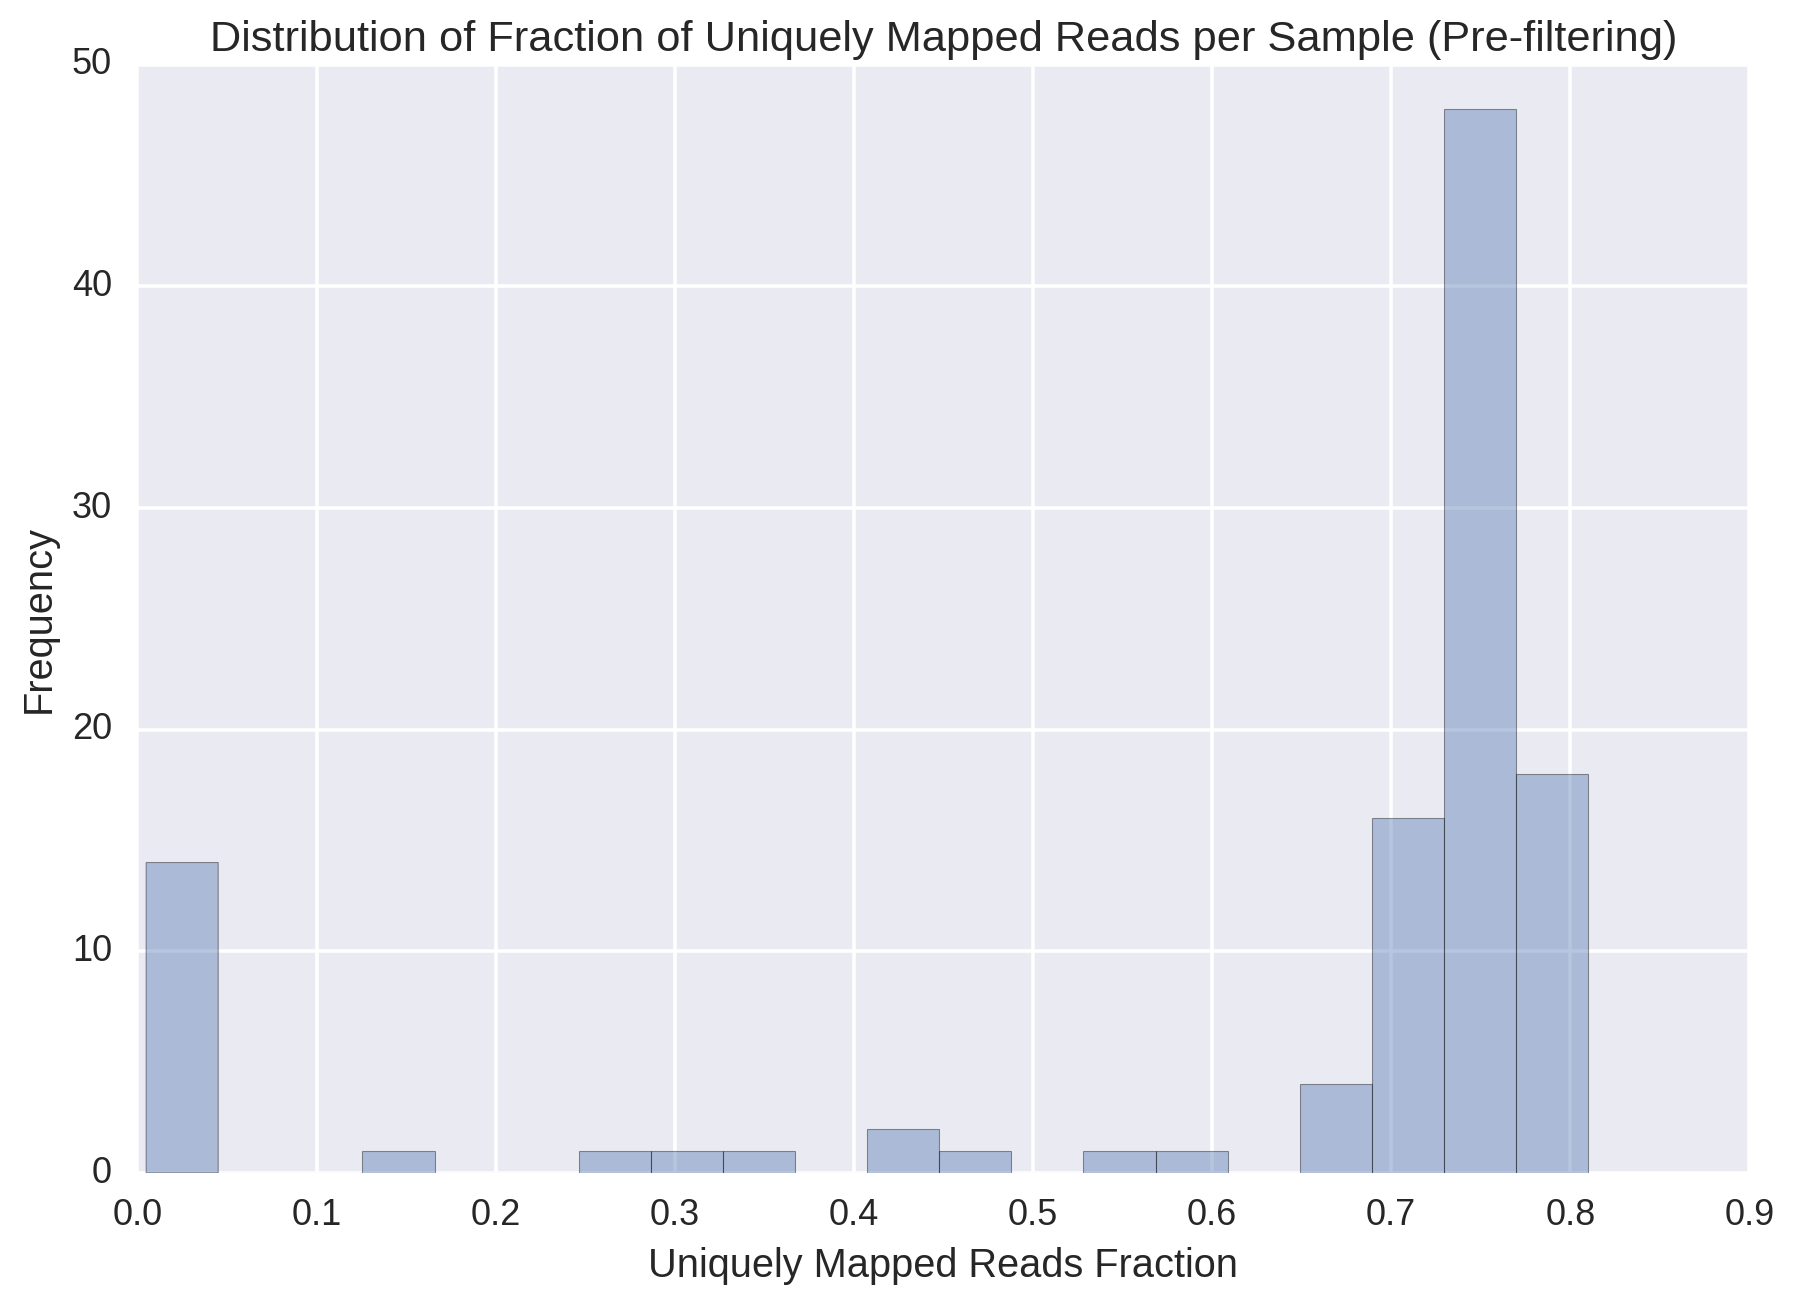

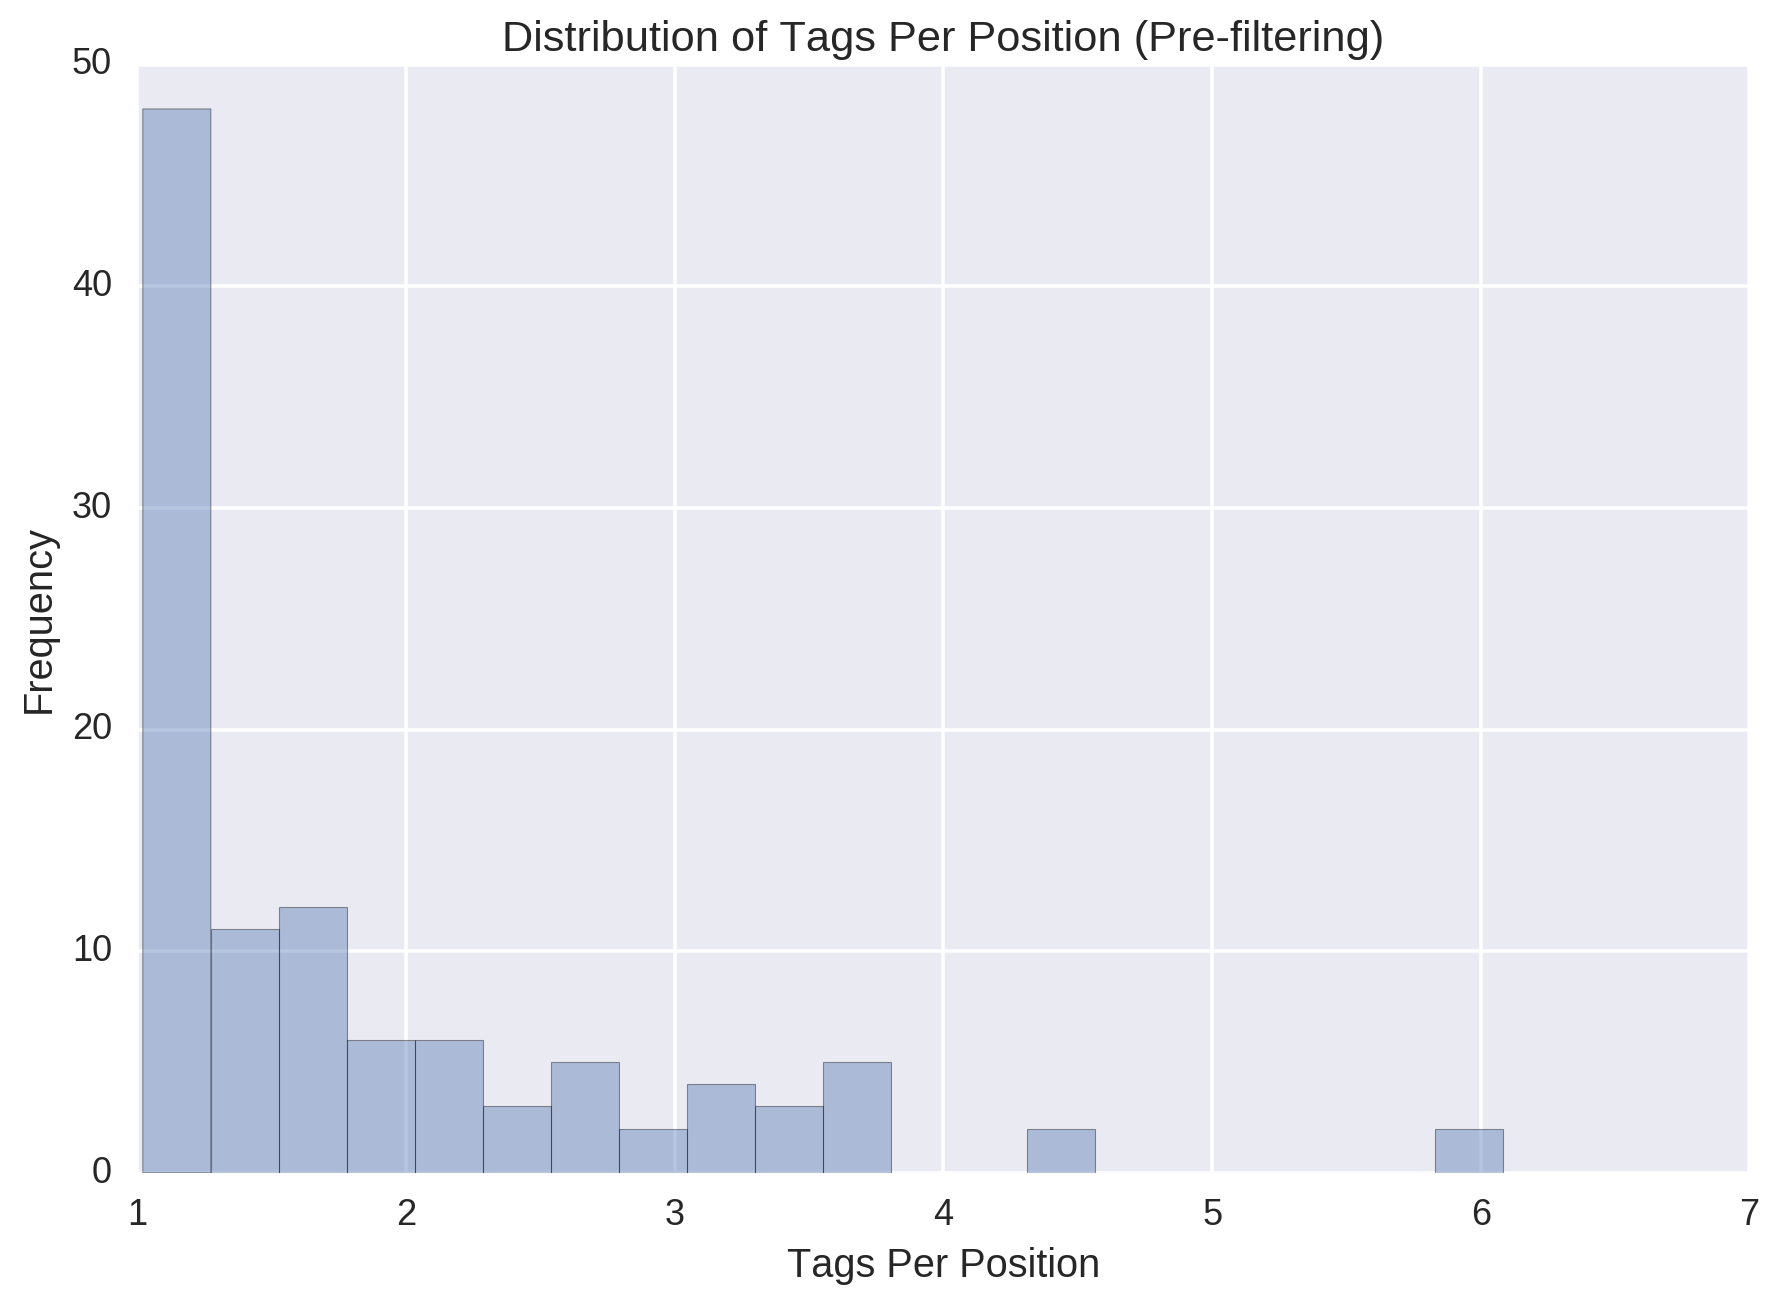

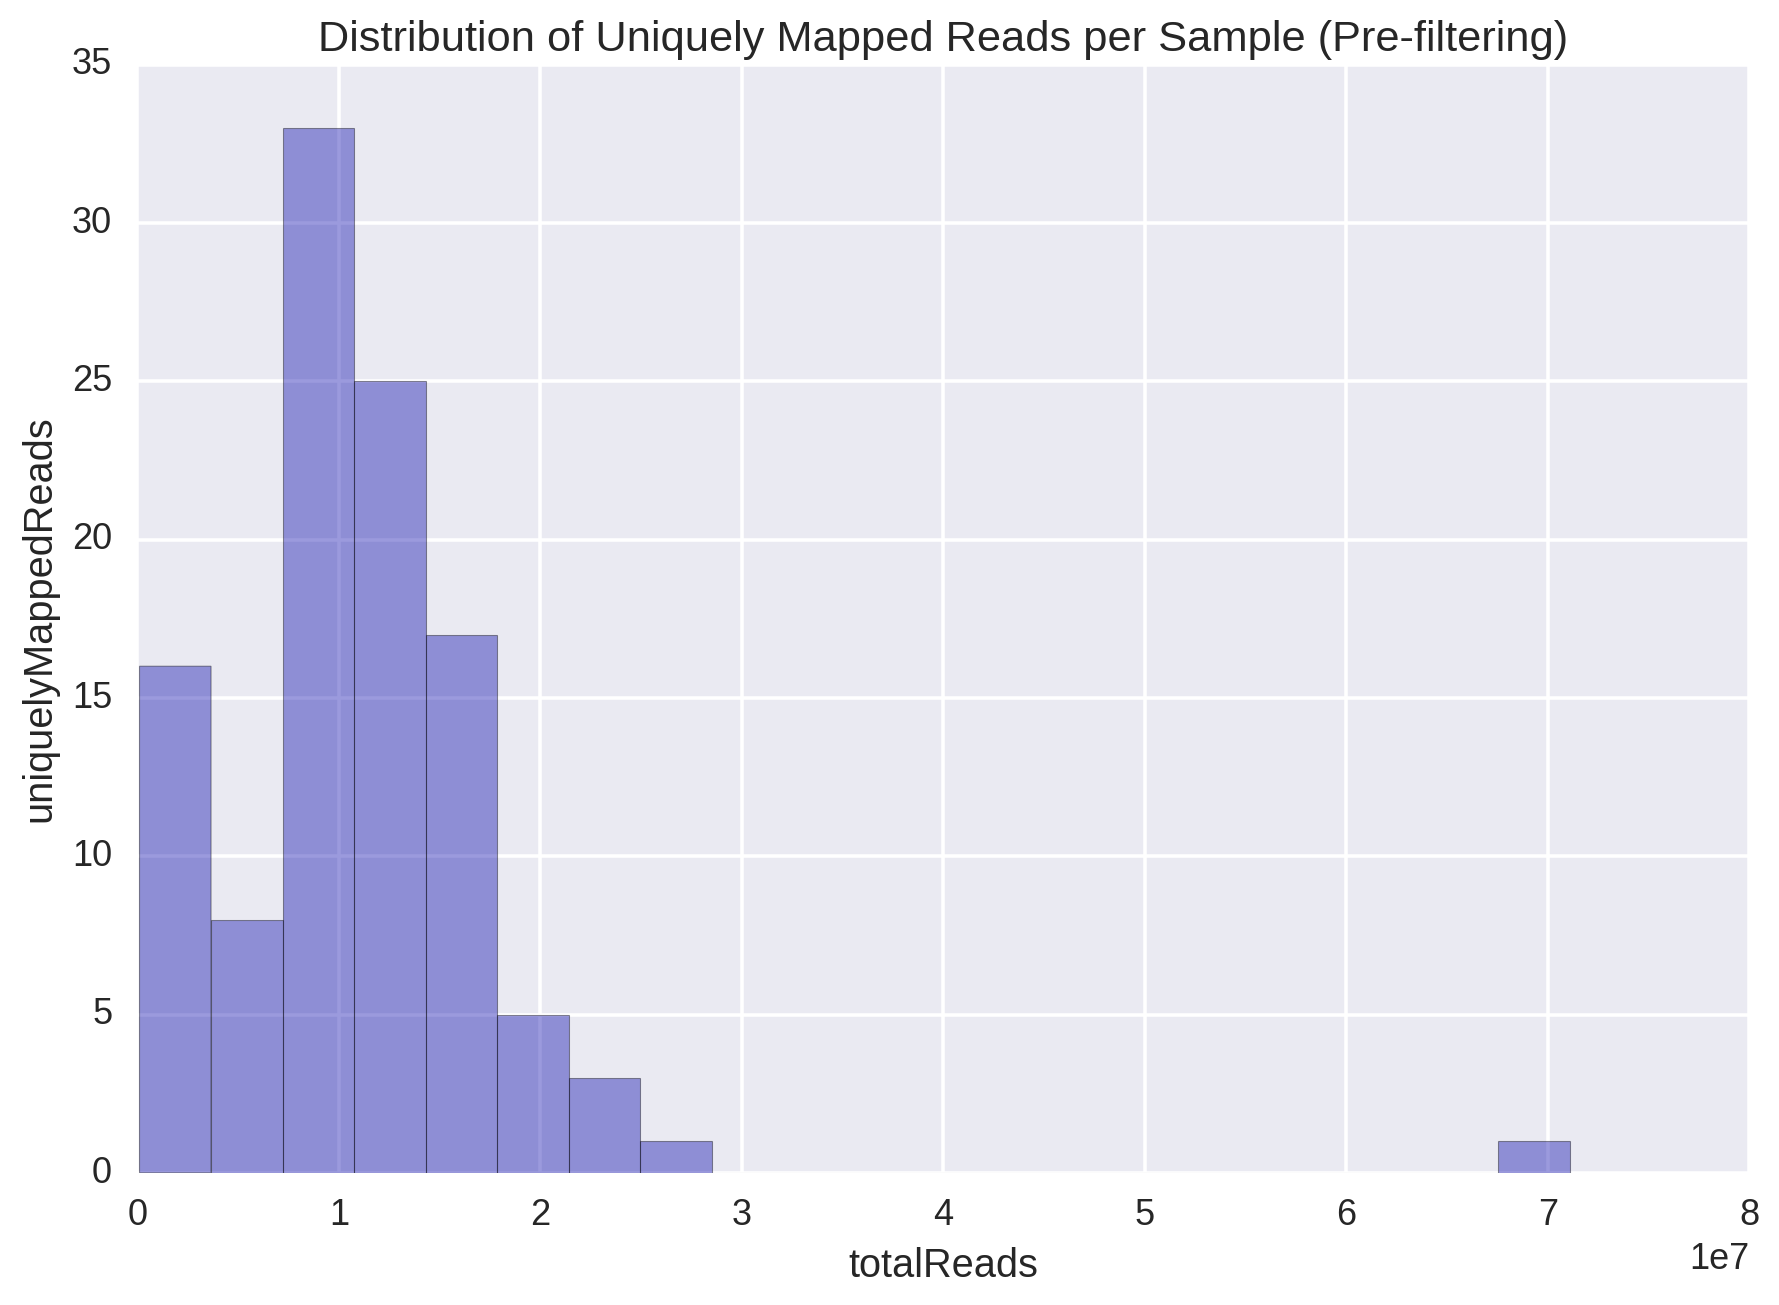

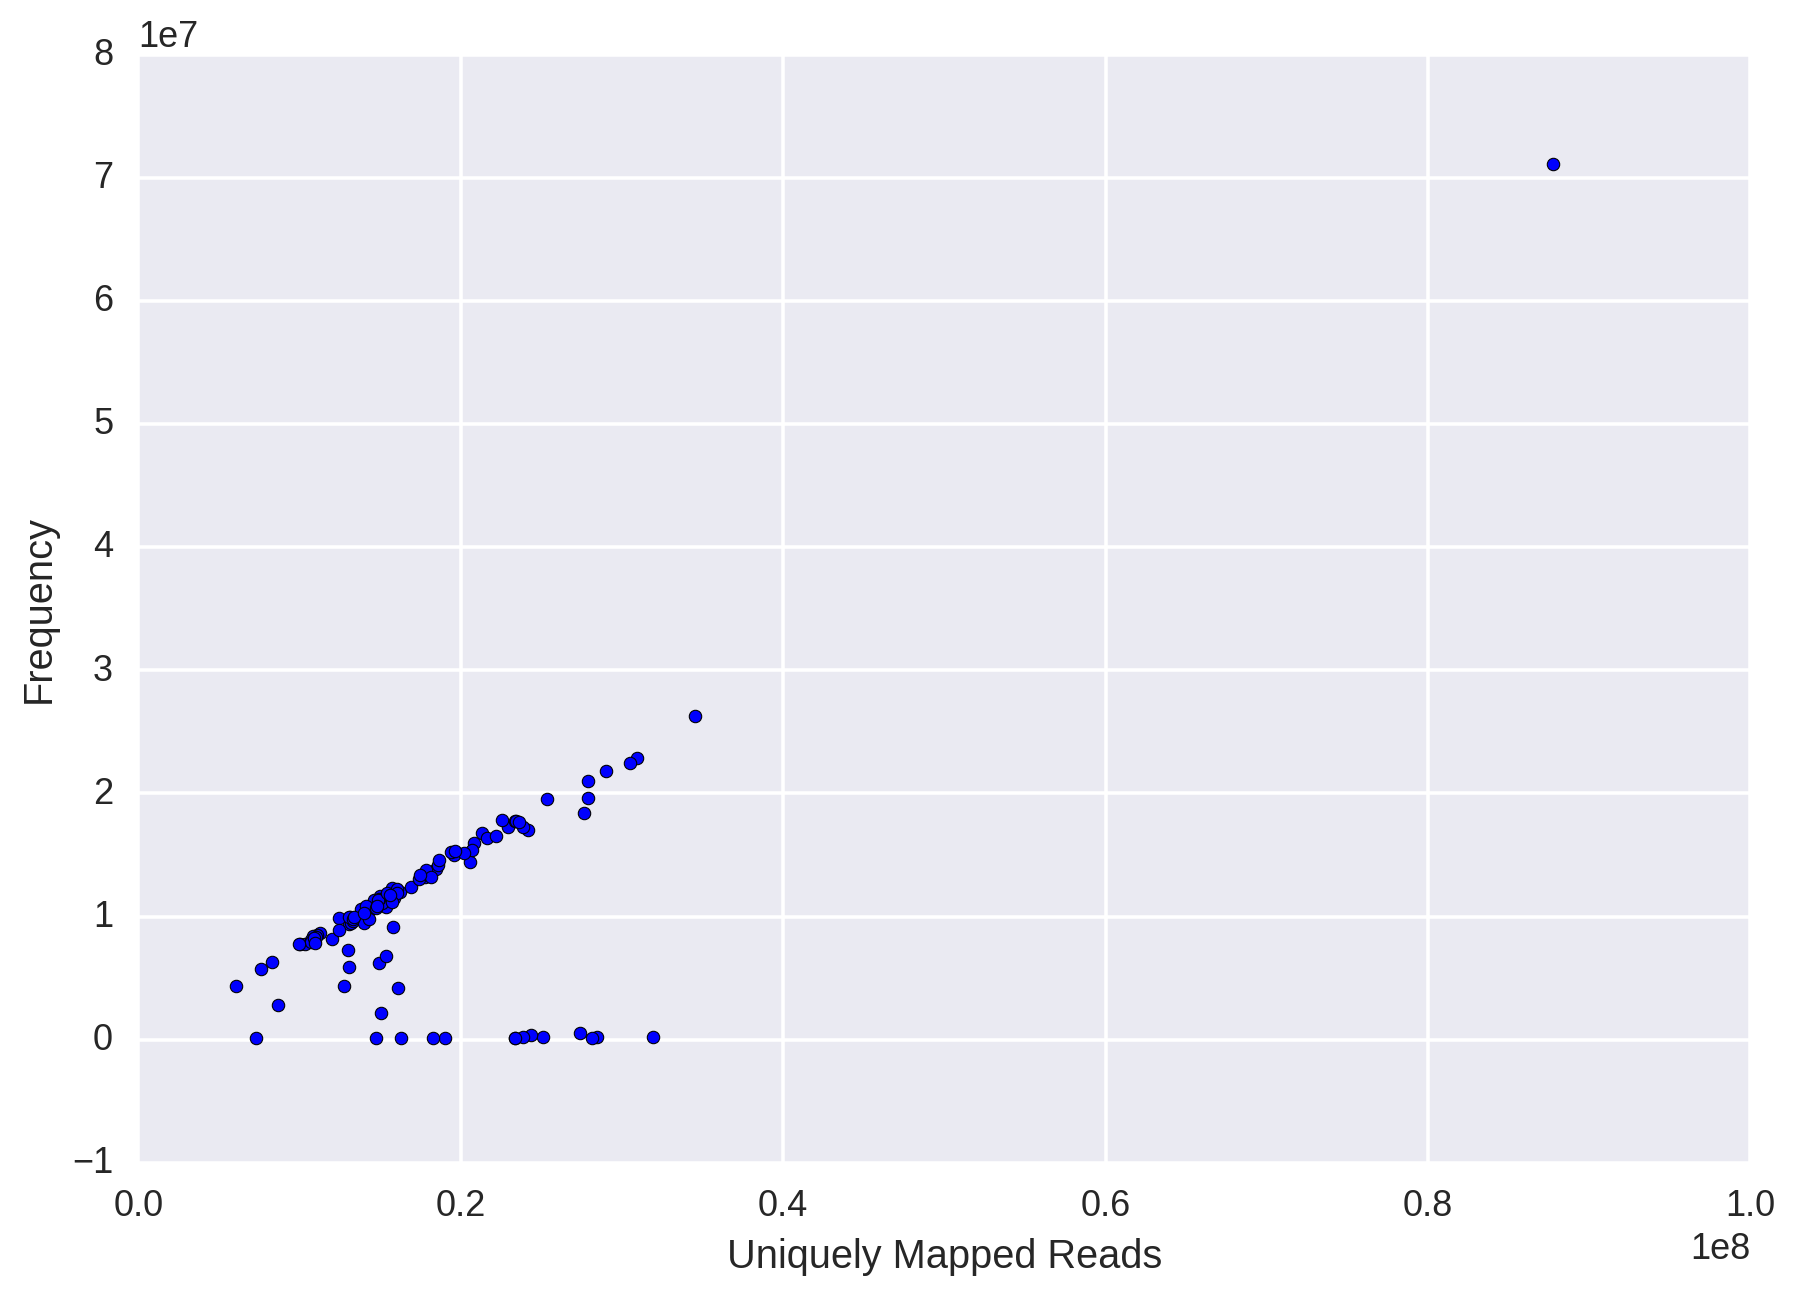

In [283]:
# plot distribution of uniquely mapped reads
sns.distplot(mapping_summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

sns.distplot(mapping_summary_frame['tagsPerPosition'], bins=20, kde=False)
plt.title('Distribution of Tags Per Position (Pre-filtering)')
plt.xlabel('Tags Per Position')
plt.ylabel('Frequency')
plt.show()

# plot distribution of PBC
# sns.distplot(summary_frame['pbc'], bins=20, kde=False)
# plt.title('Distribution of PBC (Pre-filtering)')
# plt.xlabel('PBC')
# plt.ylabel('Frequency')
# plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(mapping_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb["royal blue"])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('totalReads')
plt.ylabel('uniquelyMappedReads')
plt.show()


plt.scatter(x = mapping_summary_frame['totalReads'].astype(float).values, y=mapping_summary_frame['uniquelyMappedReads'].astype(float).values)
plt.xlabel('Uniquely Mapped Reads')
plt.ylabel('Frequency')
# sns.distplot(summary_frame['spot'], kde=False, bins =50)
# plt.show()

### Filter Samples According to Mapping Quality

In [284]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 1000000
# pbcThreshold=0.5
# spotThreshold = 0.005

filtered_summary_frame = mapping_summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]
# #filter on PBC
# filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['pbc'] >= pbcThreshold]
# print(filtered_summary_frame.shape)
# #filter on spot
# filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['spot'] >= spotThreshold]
# print(filtered_summary_frame.shape)

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame['strain'] + '_' + filtered_summary_frame['factor'] + '_' + filtered_summary_frame["simpleTreatment"]).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["originalName"])) # {newName:originalName}

sampleName_simpleName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["originalName"])) 



Number of Samples: 109
Number of discarded samples: 14
Number of Samples remaining after filtering: 95


<function xticks at 0x7ff150f7cd90>


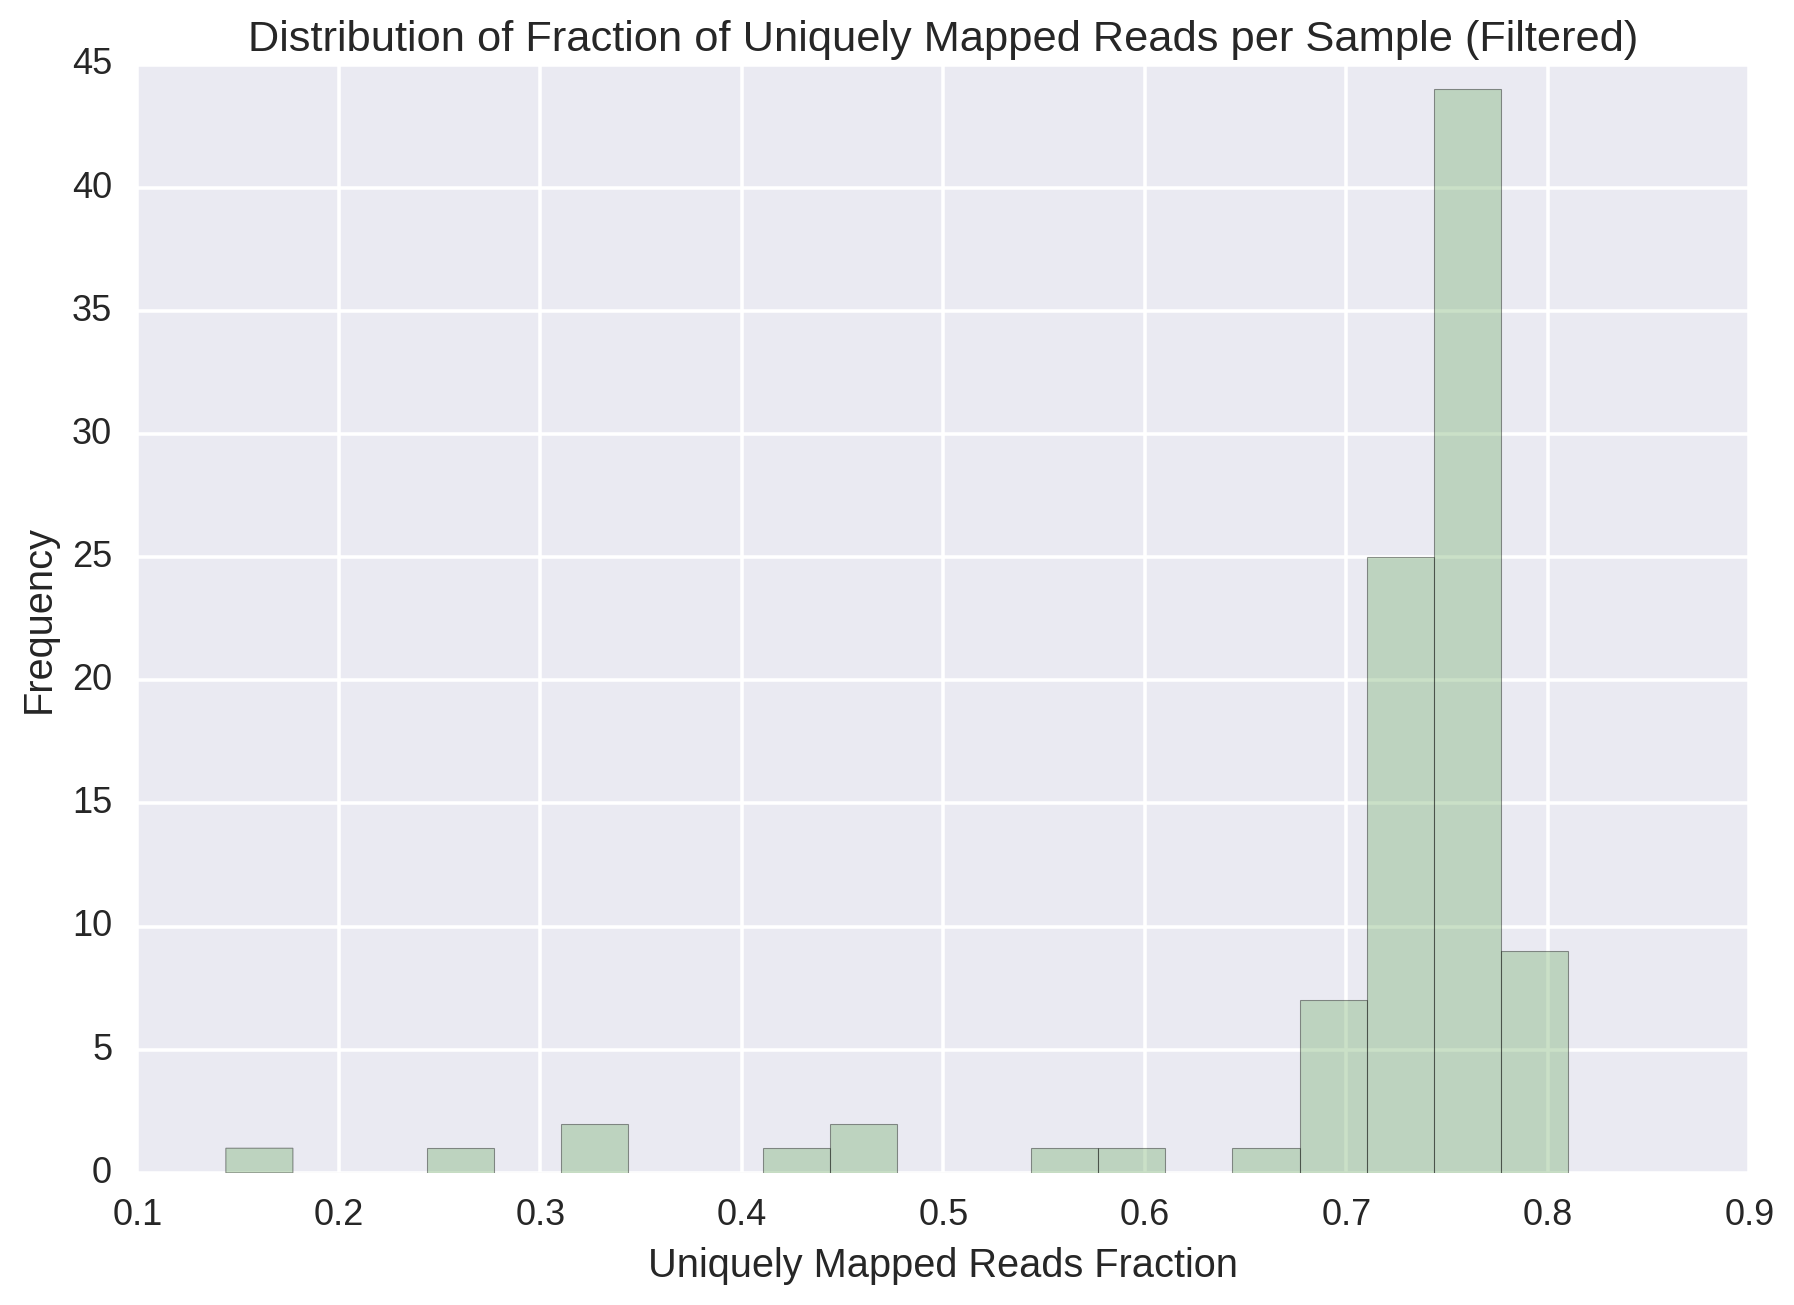

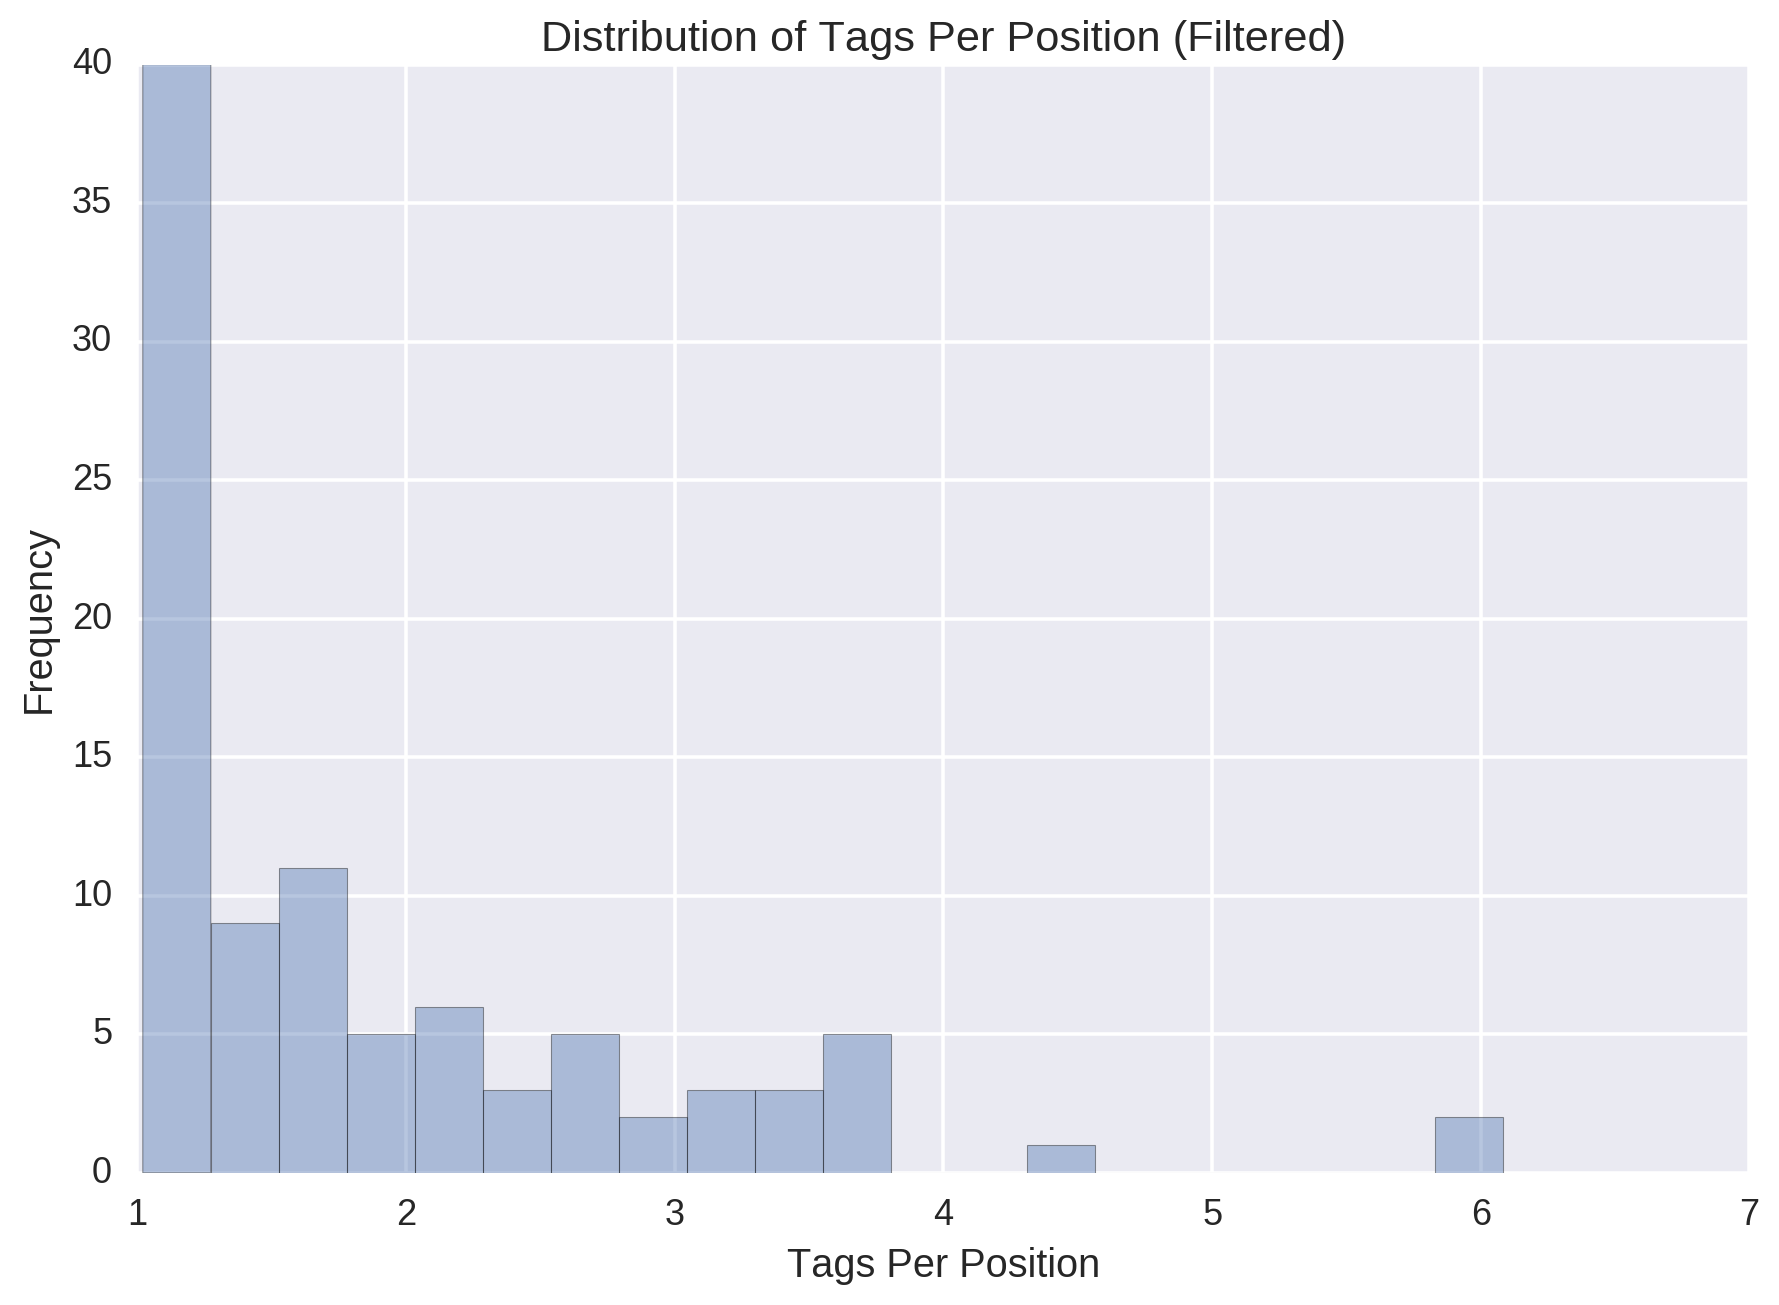

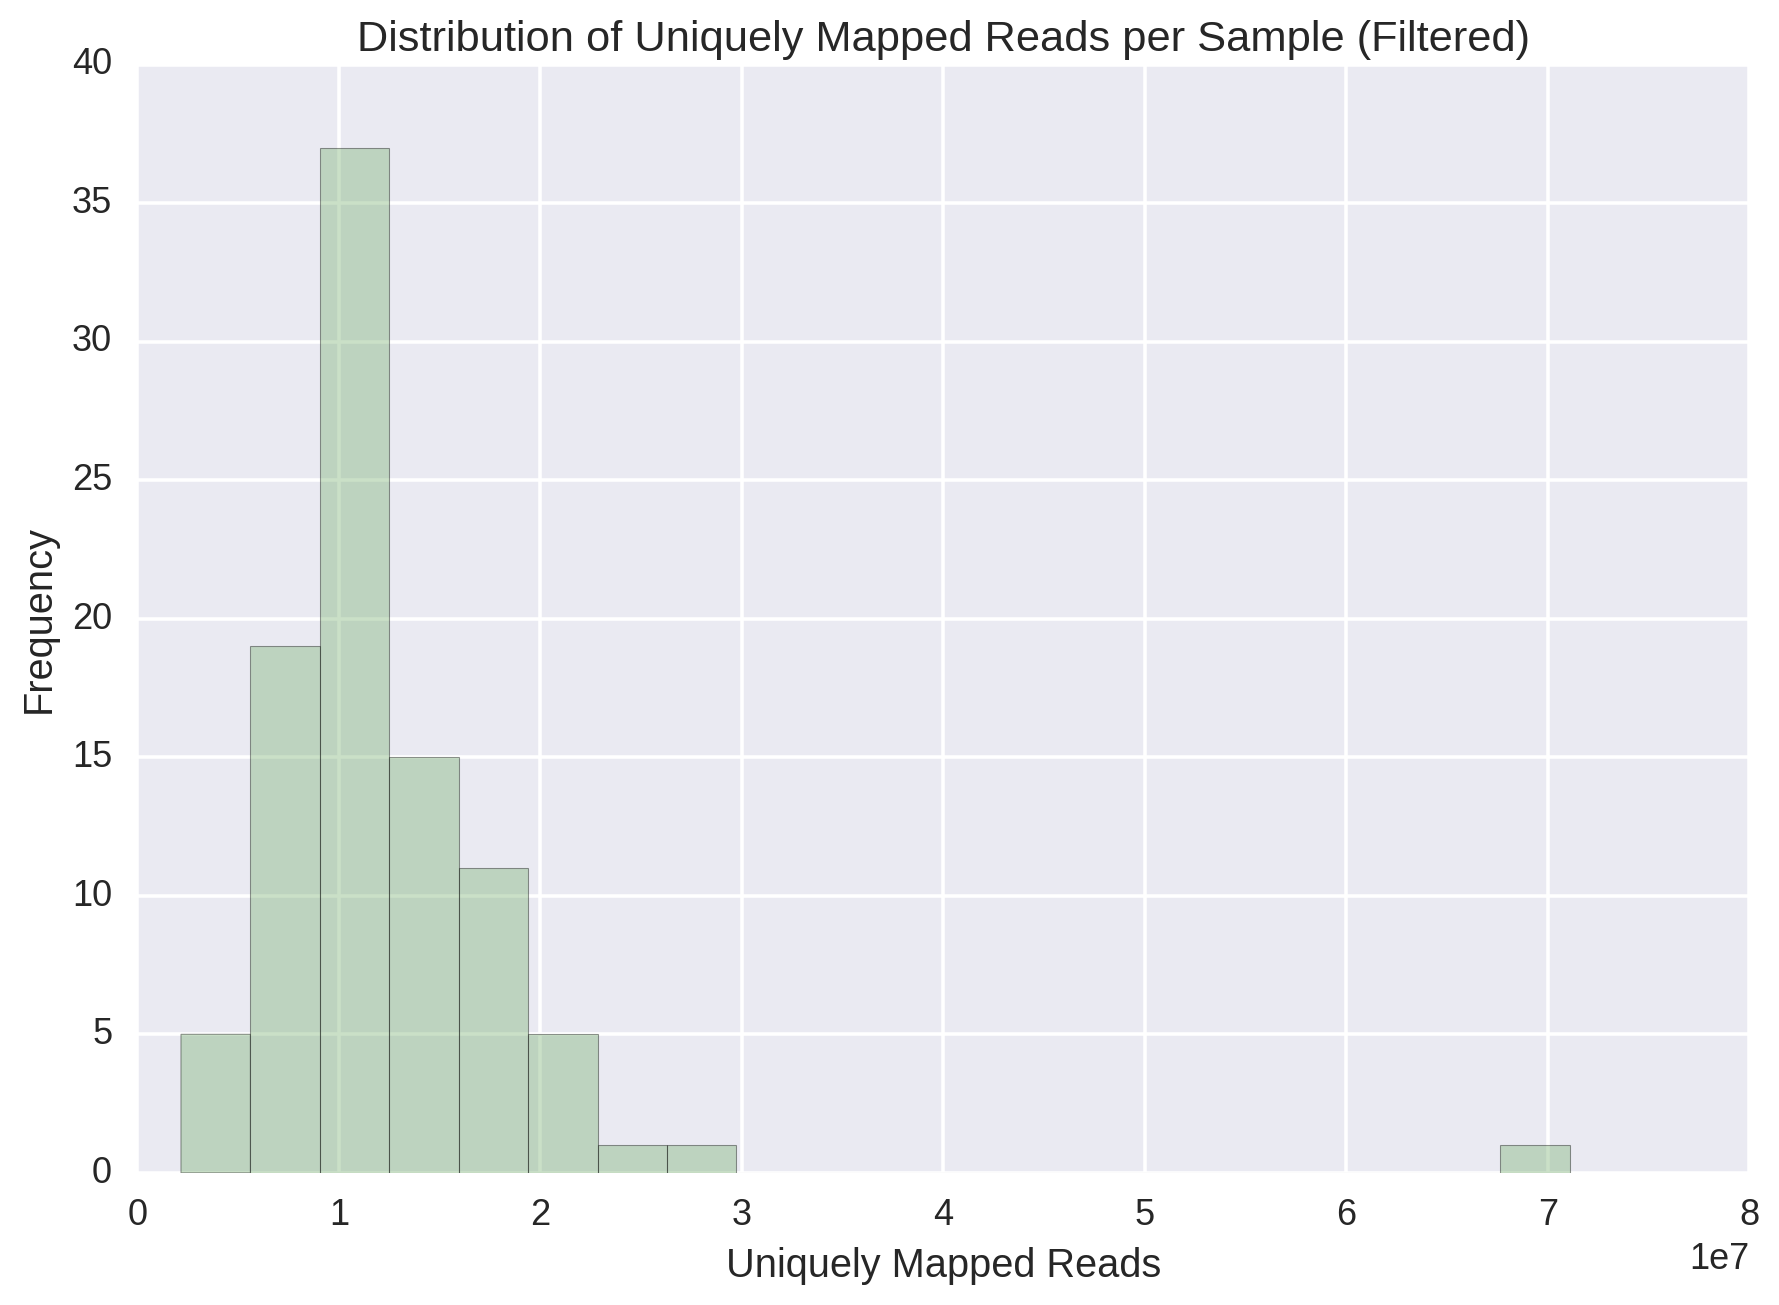

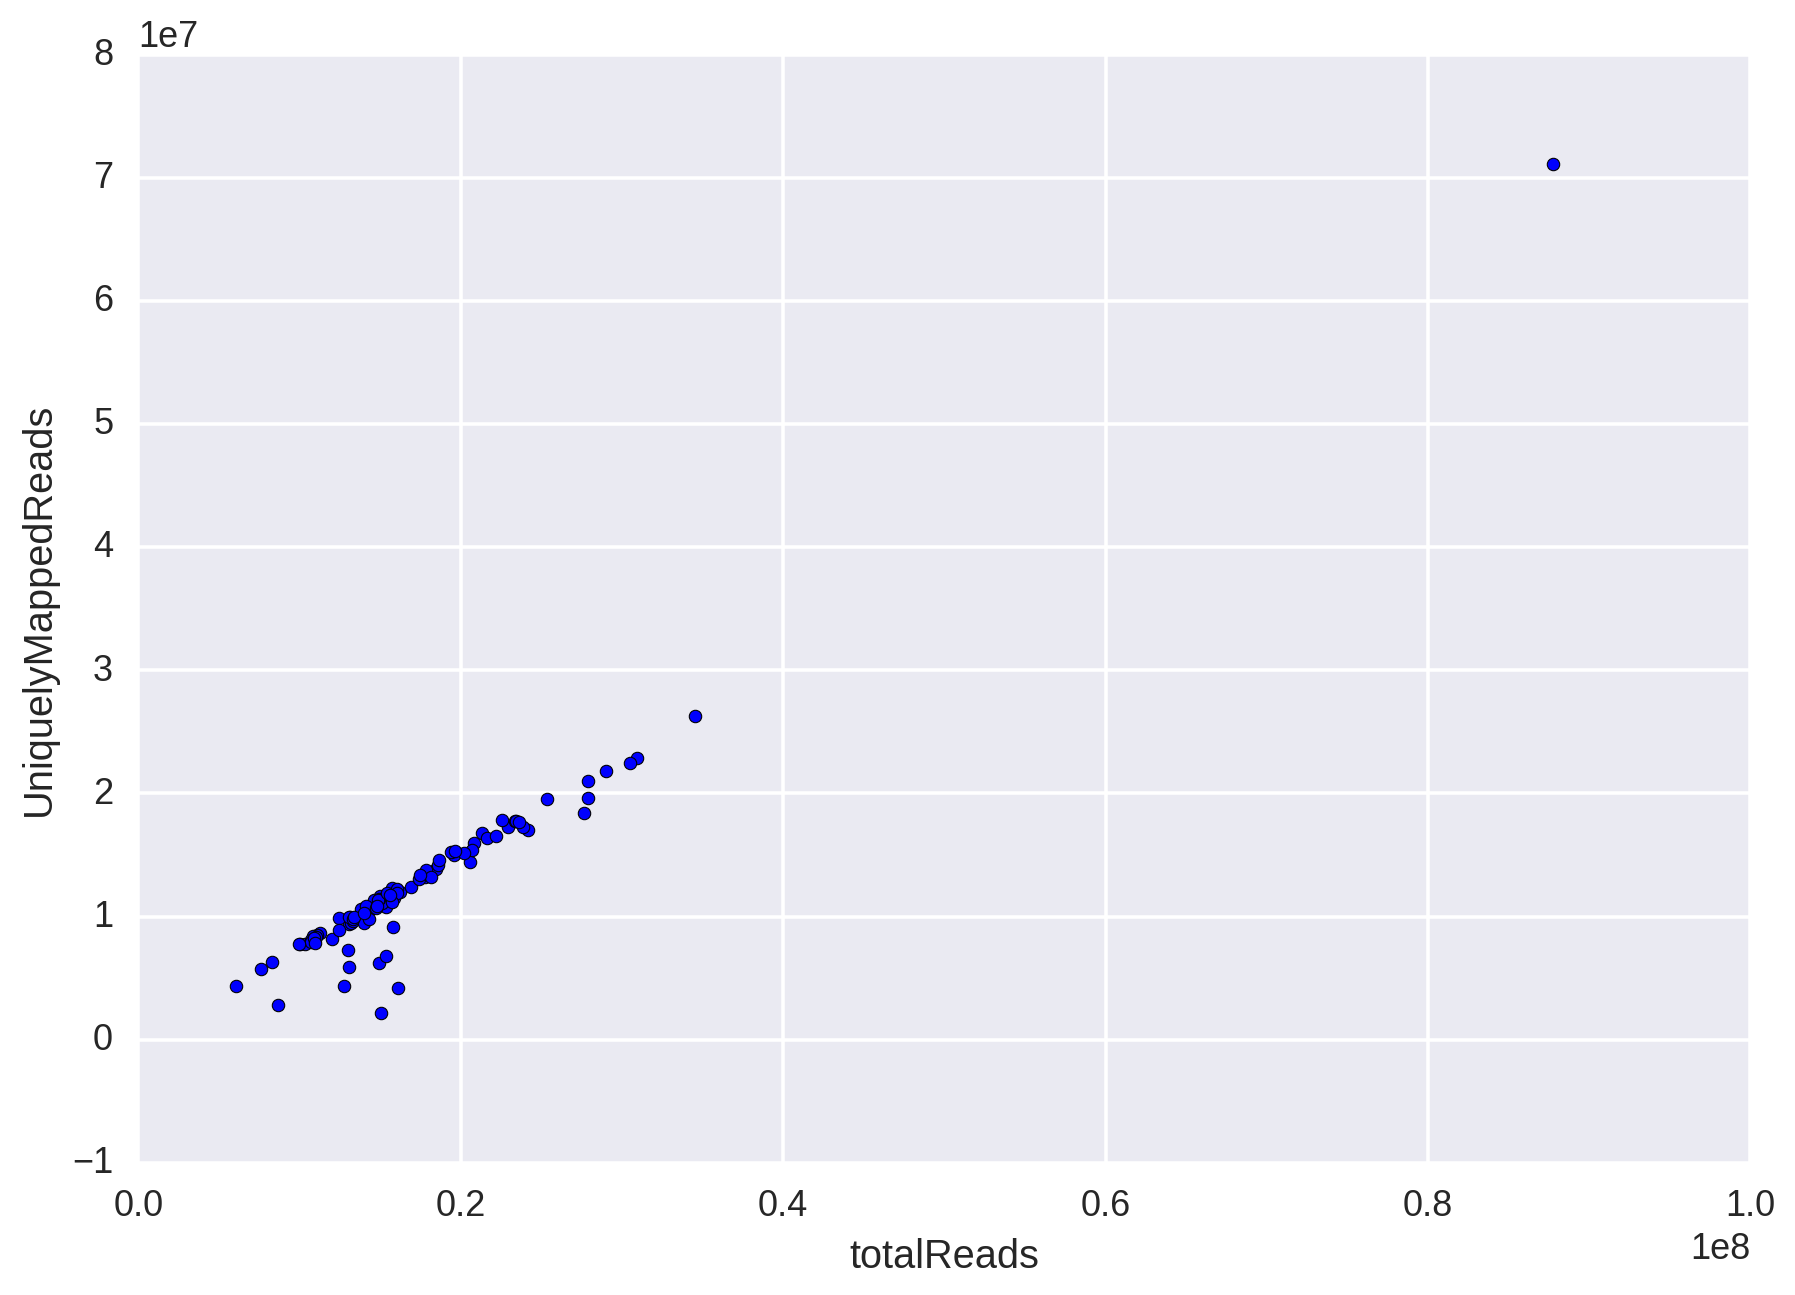

In [285]:
# plot distribution of uniquely mapped reads
sns.distplot(filtered_summary_frame['uniquelyMappedFraction'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
print(plt.xticks)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Filtered)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# plot distribution of PBC
# sns.distplot(filtered_summary_frame['pbc'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
# plt.title('Distribution of PBC (Filtered)')
# plt.xlabel('PBC')
# plt.ylabel('Frequency')
# plt.show()

sns.distplot(filtered_summary_frame['tagsPerPosition'], bins=20, kde=False)
plt.title('Distribution of Tags Per Position (Filtered)')
plt.xlabel('Tags Per Position')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(filtered_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Filtered)')
plt.xlabel('Uniquely Mapped Reads')
plt.ylabel('Frequency')
plt.show()


plt.scatter(filtered_summary_frame['totalReads'], filtered_summary_frame['uniquelyMappedReads'])
plt.xlabel('totalReads')
plt.ylabel('UniquelyMappedReads')
plt.show()

# plt.boxplot([discarded_summary_frame["spot"], filtered_summary_frame["spot"]])
# plt.xticks([1, 2], ["discarded", "not discarded"])
# plt.ylabel("SPOT")
# plt.show()

# plt.boxplot([discarded_summary_frame["pbc"], filtered_summary_frame["pbc"]])
# plt.ylabel("PBC Coefficient")
# plt.xticks([1, 2], ["discarded", "not discarded"])
# plt.show()

## Peak Calling

In [295]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open(scratchDirectory + '/peakCalling_homer_idr.sh', 'w')
scriptFile2 = open(scratchDirectory + '/peakCalling_homer.sh', 'w')


for tagDir in filtered_summary_frame['originalName'].values:
    # call peaks only for experiments that passed thresholding
    metaDataTokens = originalName_cleanedName_dict[tagDir].split("_")
    treatment = metaDataTokens[4]
    date = metaDataTokens[6]

    peakFileName1 = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
    peakFileName2 = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"


    if "veh" in treatment.lower():
        inputDir = '/home/jenhan/analysis/ap1_analysis/input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20'
    elif "kla" in treatment.lower():
        inputDir = '/home/jenhan/analysis/ap1_analysis/input_data/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20'
    scriptFile1.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                     ' -i ' + inputDir
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -style factor -size 200  > ' + 
                     peakDirectory +'/' + peakFileName1 + ' &\n')
    scriptFile2.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                 ' -i ' + inputDir
                 + ' -style factor -size 200  > ' + 
                 peakDirectory +'/' + peakFileName2 + ' &\n')
scriptFile1.close()
scriptFile2.close()



In [ ]:
%%bash
rm ./peak_files/*
chmod a+x ./scratch/*
bash ./scratch/peakCalling_homer_idr.sh

## Run IDR

In [313]:
idrDirectory = '/home/jenhan/analysis/ap1_analysis/ap1_idr/'

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
!rm ./ap1_idr/*
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            ! python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory
            

Performing IDR analysis on the following samples: /home/jenhan/analysis/ap1_analysis/peak_files//c57bl6_cjun_veh_1_peaks.tsv, /home/jenhan/analysis/ap1_analysis/peak_files//c57bl6_cjun_veh_2_peaks.tsv
Output files will be written to: /home/jenhan/analysis/ap1_analysis/ap1_idr/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score'
 'Total Tags (normalized to Control Experiment)' 'Control Tags'
 'Fold Change vs Control' 'p-value vs Control' 'Score']
idr --samples /home/jenhan/analysis/ap1_analysis/ap1_idr//c57bl6_cjun_veh_1_peaks.narrowPeak /home/jenhan/analysis/ap1_analysis/ap1_idr//c57bl6_cjun_veh_2_peaks.narrowPeak --output-file /home/jenhan/analysis/ap1_analysis/ap1_idr//c57bl6_cjun_veh_1_peaks_c57bl6_cjun_veh_2_peaks_idr.out --plot --idr-threshold 0.05 &
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [2.08 1.09 0.71 0.67]
/bioinformatics/softwa

(0, 20000)

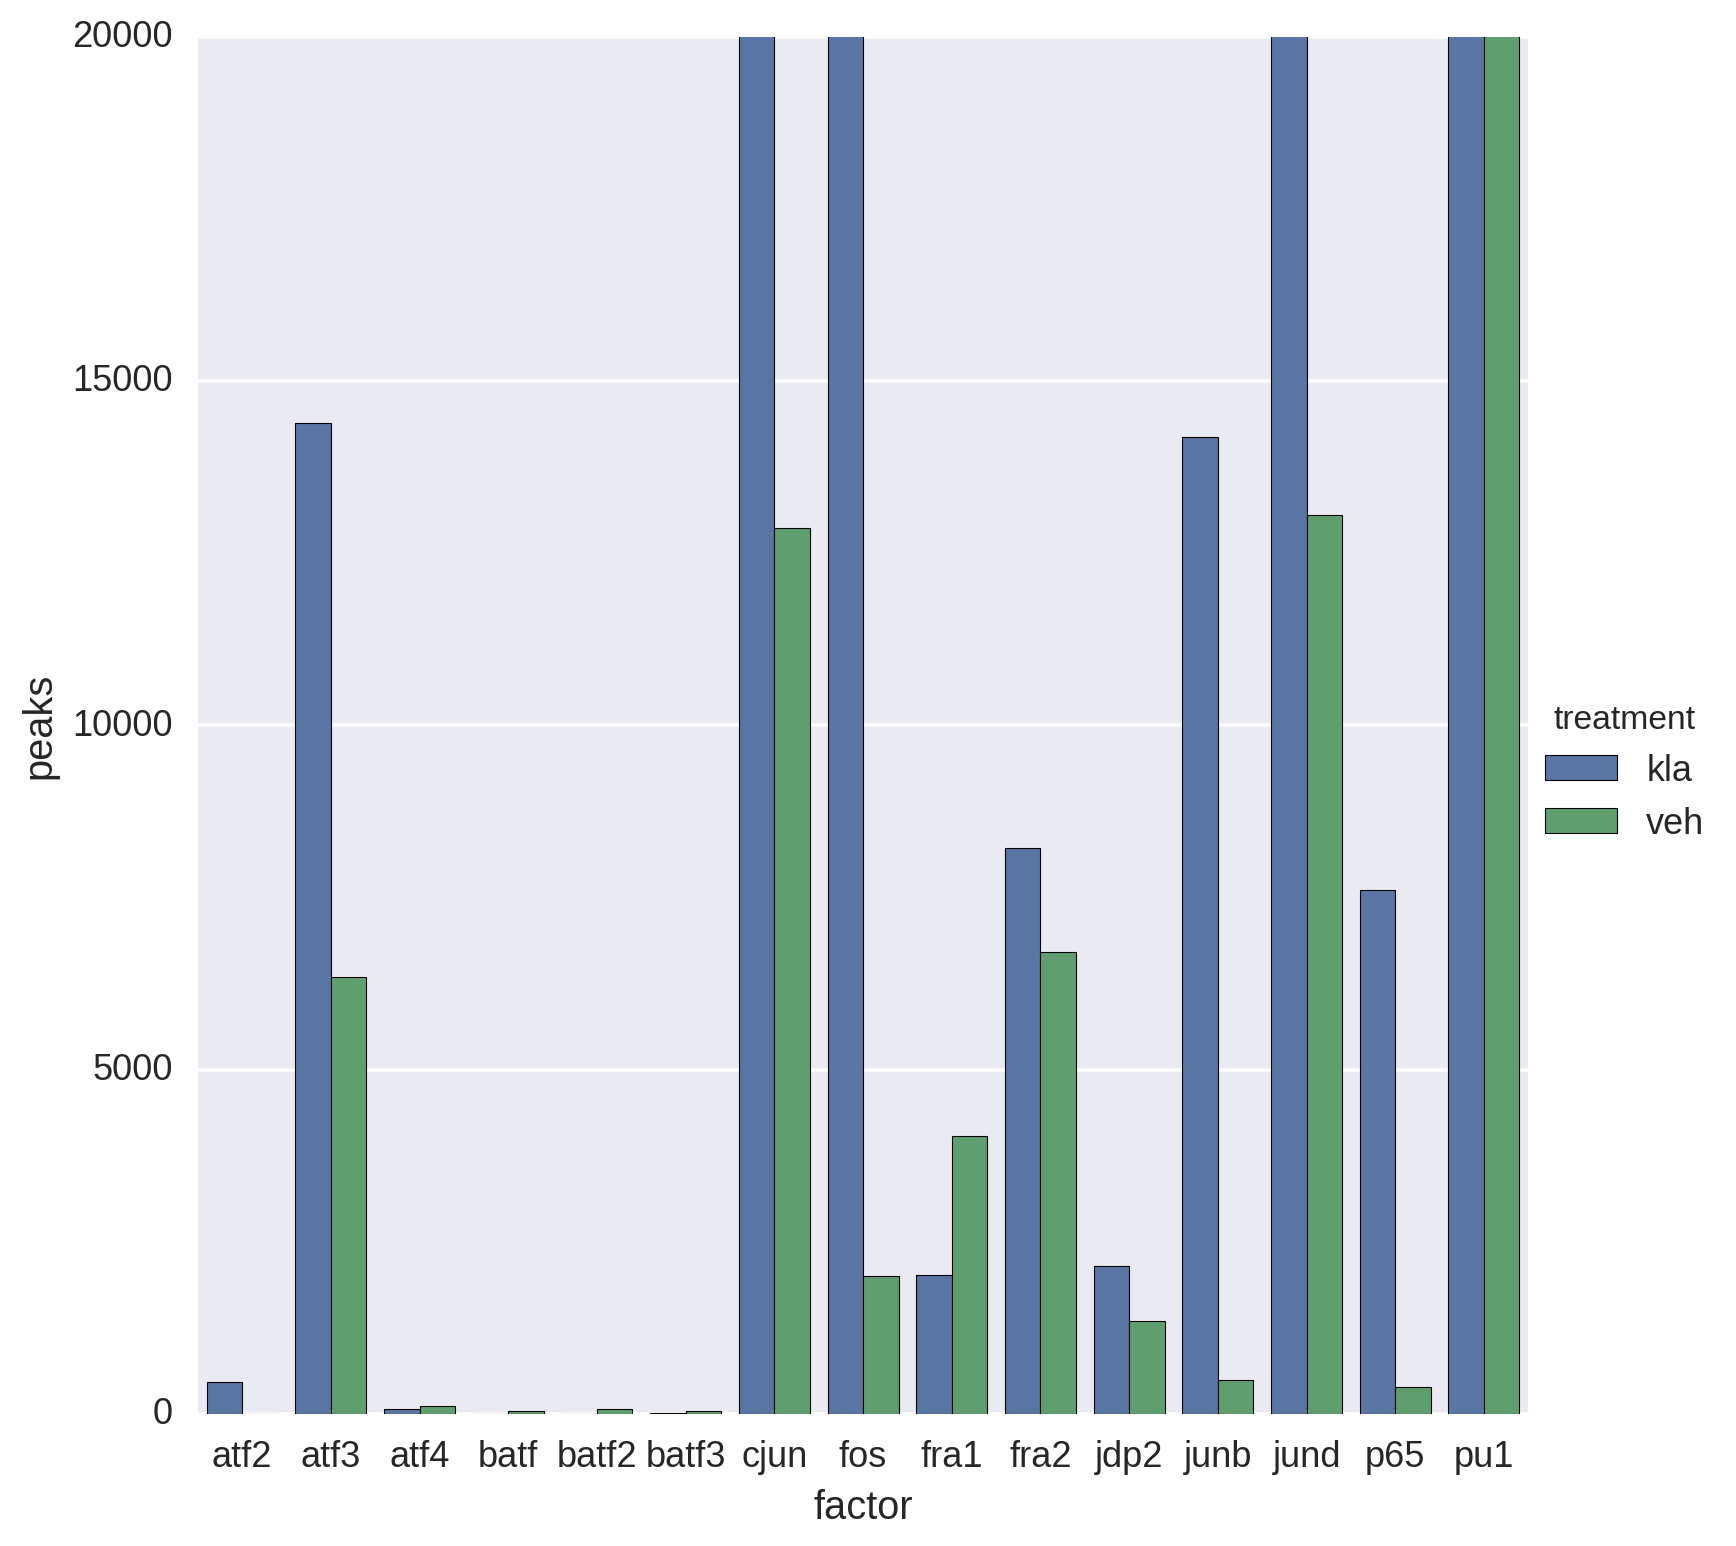

In [314]:
# pick the IDR results that have the most peaks
idrDirectory = '/home/jenhan/analysis/ap1_analysis/ap1_idr/'
factorTreatment_bestIDR_dict = {}
factorTreatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        factorTreatment = '_'.join(p.split('_')[:3])
        if factorTreatment in factorTreatment_peakNumber_dict:
            if factorTreatment_peakNumber_dict[factorTreatment] < numPeaks:
                factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
                factorTreatment_bestIDR_dict[factorTreatment] = p
        else:
            factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
            factorTreatment_bestIDR_dict[factorTreatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for factorTreatment in factorTreatment_peakNumber_dict.keys():
    tokens = factorTreatment.split('_')
    strains.append(tokens[0])
    factors.append(tokens[1])
    treatments.append(tokens[2])
    numPeaks.append(factorTreatment_peakNumber_dict[factorTreatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'factor':factors,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['factor'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='factor', y='peaks', data = idrPeak_frame, hue='treatment', size =8, kind='bar')
plt.ylim([0,20000])
    

In [315]:
! if [ ! -d idrPeaks ]; then mkdir idrPeaks; fi
!rm ./idrPeaks/*
for key in factorTreatment_bestIDR_dict.keys():
    p = factorTreatment_bestIDR_dict[key]
    if factorTreatment_peakNumber_dict[key] > 0:
        outpath = './idrPeaks/' + '_'.join(p.split('_')[1:3]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
# ! cp /home/jenhan/analysis/ncor_analysis/peak_files/ncor_notx_peaks.tsv idrPeaks/ncor_veh_peaks.tsv  
# ! cp /home/jenhan/analysis/ncor_analysis/peak_files/ncor_kla_peaks.tsv idrPeaks/ncor_kla_peaks.tsv  



In [136]:
# create group summary file
!bash /home/jenhan/code/seq_merge_pipe/makeSummaryFile.sh /home/jenhan/analysis/ap1_analysis/idrPeaks/* > /home/jenhan/analysis/ap1_analysis/group_summary.tsv
! cp merged.tsv merged_peaks.tsv

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total) and /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total)
	Comparing /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total) and /home/jenhan/analysis/ap1_analysis/idrPeaks/atf3_kla_peaks.tsv (2121 total)
	Comparing /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total) and /home/jenhan/analysis/ap1_analysis/idrPeaks/atf3_veh_peaks.tsv (1099 total)
	Comparing /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total) and /home/jenhan/analysis/ap1_analysis/idrPeaks/atf4_kla_peaks.tsv (43 total)
	Comparing /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total) and /home/jenhan/analysis/ap1_analysis/idrPeaks/atf4_veh_peaks.tsv (78 total)
	Comparing /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total) and /home/jenhan/a

In [228]:
# annotate peaks with enhancer marks
!annotatePeaks.pl /home/jenhan/analysis/ap1_analysis/merged_peaks.tsv mm10 -size 1000 -d tag_directories_enhancerMarks/* > merged_annotated_peaks.tsv


	Peak file = /home/jenhan/analysis/ap1_analysis/merged_peaks.tsv
	Genome = mm10
	Organism = mouse
	Peak Region set to 1000
	Tag Directories:
		tag_directories_enhancerMarks/C57Bl6_ThioMac_GRO_KLA-1h_NJS_10-08-13
		tag_directories_enhancerMarks/C57Bl6_ThioMac_GRO_KLA-1h_NJS_10-09-01
		tag_directories_enhancerMarks/C57Bl6_ThioMac_GRO_notx-1h_NJS_10-08-13
		tag_directories_enhancerMarks/C57Bl6_ThioMac_GRO_notx-1h_NJS_10-09-01
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K27Ac_KLA-1h_CR_12-07-06
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K27Ac_notx_CR_12-07-06
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K4me1_KLA-1h_Josh_13-02-07
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K4me1_KLA-1h_Josh_14-04-22
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K4me1_notx-1h_Josh_13-02-07
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K4me1_notx-1h_Josh_14-04-22
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 21906
		Duplicated Peak I

In [14]:
# read in peak data data
summary_frame = pd.read_csv('/home/jenhan/analysis/ap1_analysis/group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[4:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.max([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
    
summary_frame['chr'] = [x.split(':')[0] for x in summary_frame['Position'].values]
summary_frame['numFactors'] = [len(x.split(',')) for x in summary_frame['Factors'].values]


summary_frame.index = summary_frame['ID'].values
newCols = list(summary_frame.columns.values)[:4] + ['chr', 'numFactors'] + list(summary_frame.columns.values)[4:-2]

summary_frame = summary_frame[newCols]



del summary_frame['Group Number']
del summary_frame['numFactors']

_factors = sorted(set(list(set([x.split('_')[0] for x in summary_frame.columns if '_' in x]))))

columns = summary_frame.columns
for f in _factors:
    if not f + '_veh' in columns:
        summary_frame[f + '_veh'] = [0.0] * summary_frame.shape[0]
    if not f + '_kla' in columns:
        summary_frame[f + '_kla'] = [0.0] * summary_frame.shape[0]

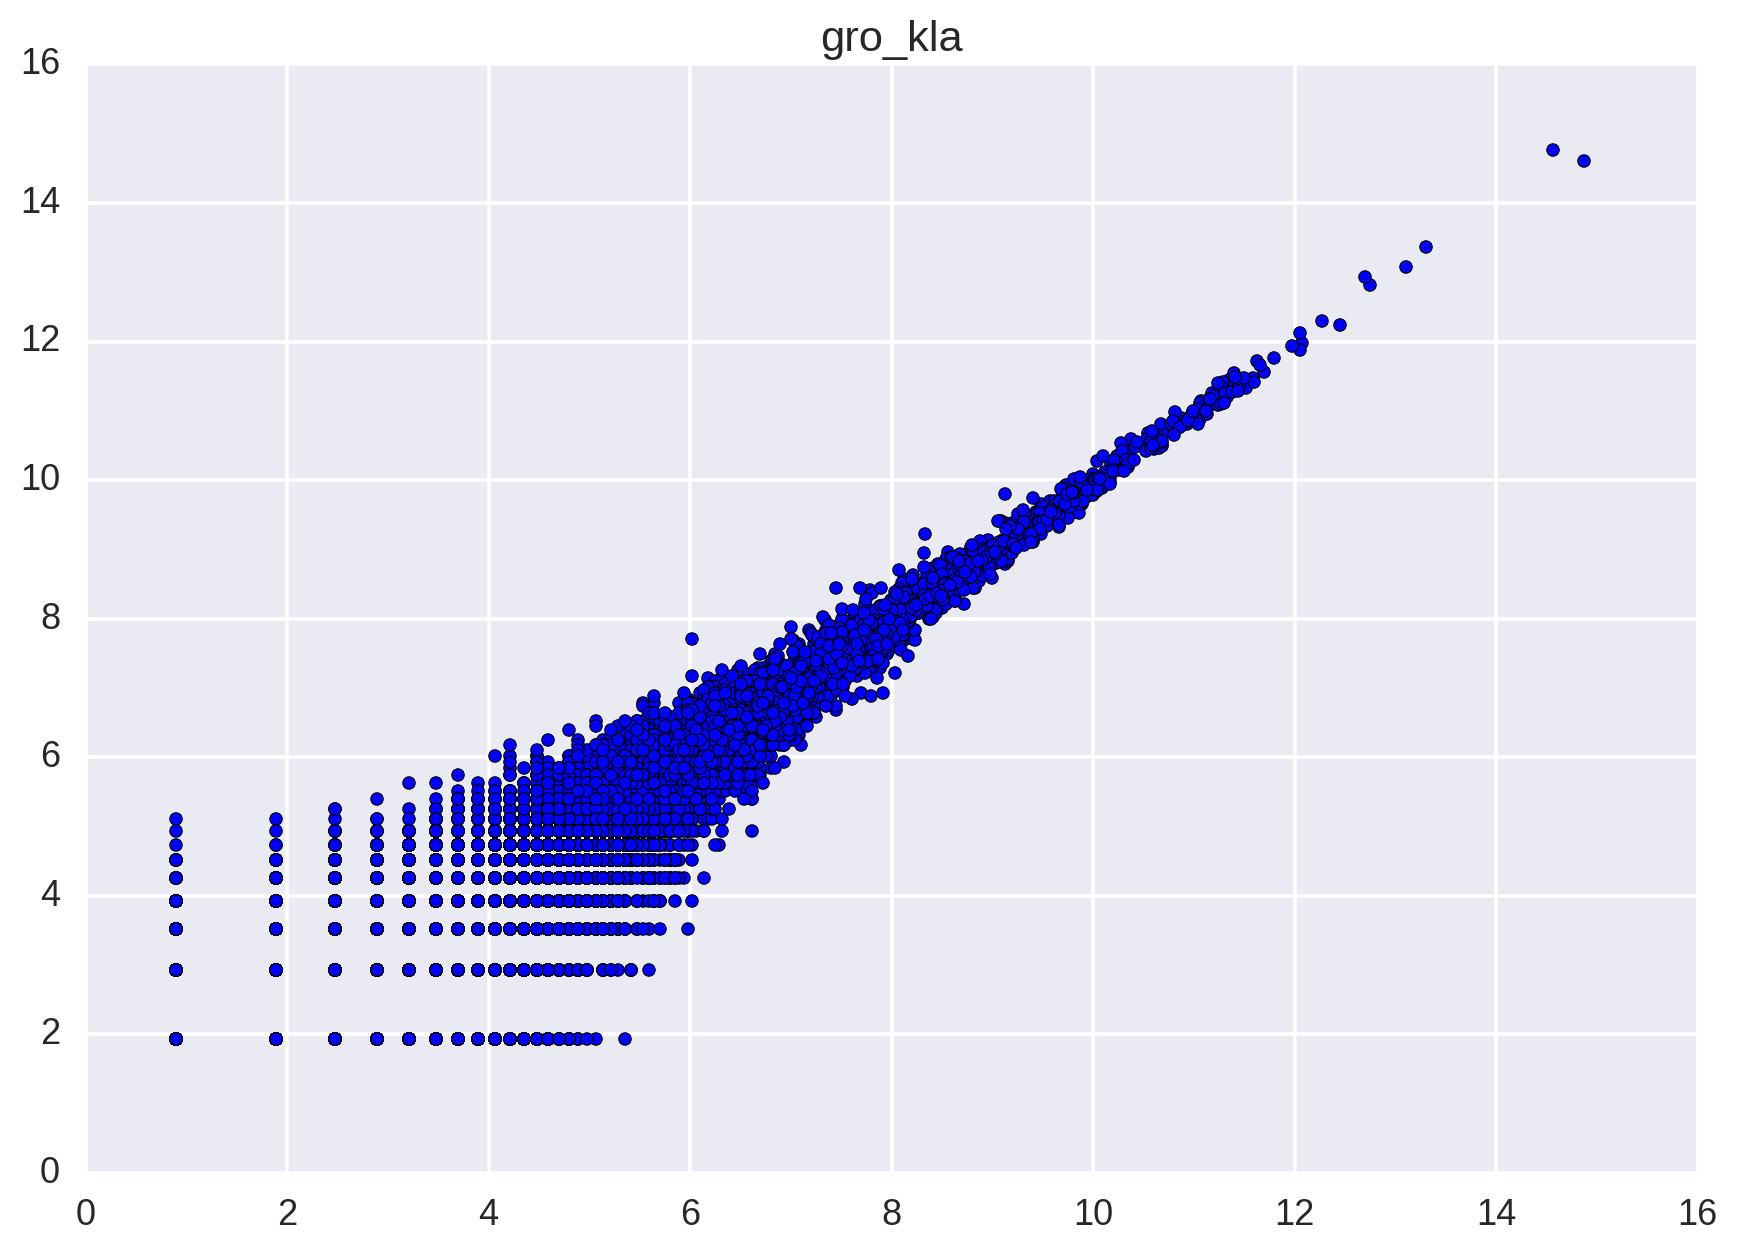

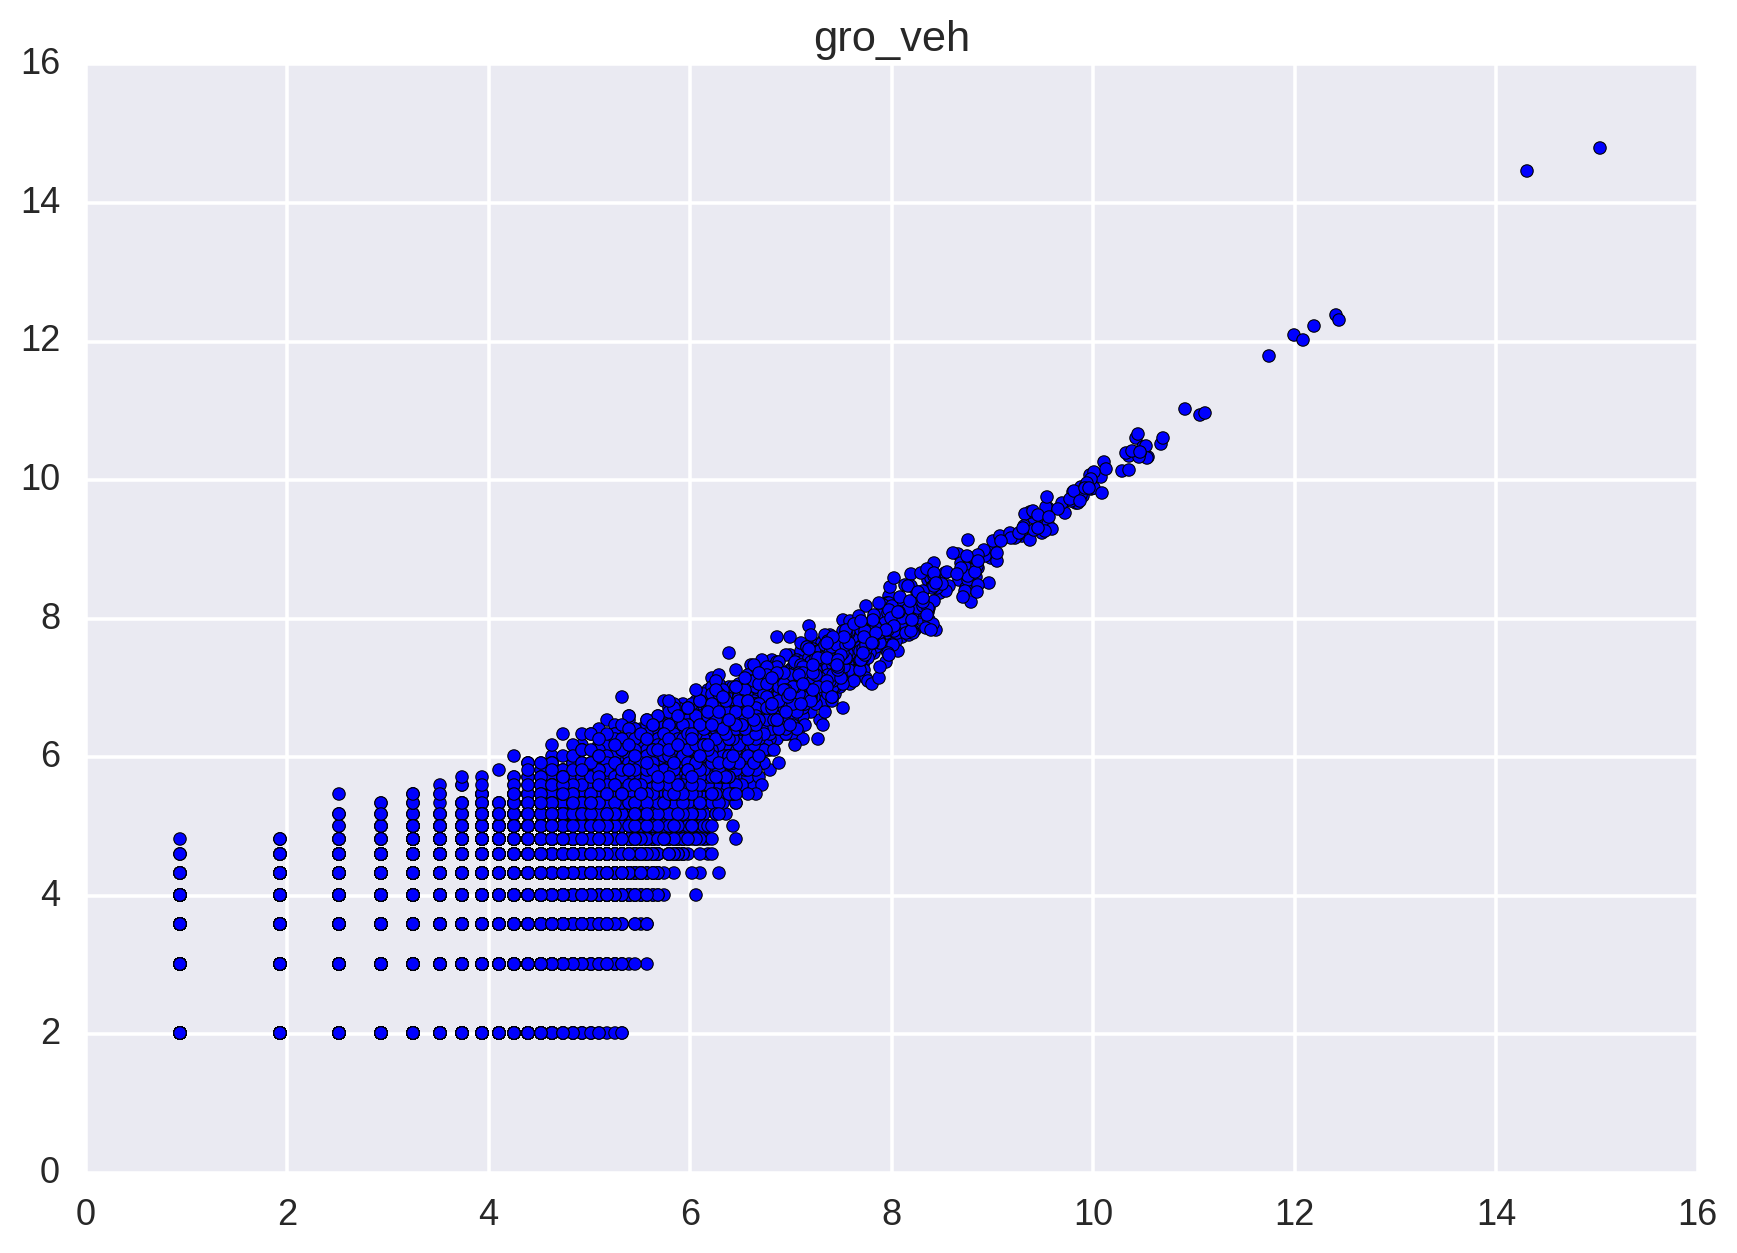

In [21]:
# read in enhancer marks
enhancer_frame = pd.read_csv('merged_annotated_peaks.tsv', sep='\t')
enhancer_frame.index=enhancer_frame.ix[:,0].values
for i in [
'Chr',
 'Start',
 'End',
 'Strand',
 'Peak Score',
 'Focus Ratio/Region Size',
 'Detailed Annotation',
 'Distance to TSS',
 'Nearest PromoterID',
 'Entrez ID',
 'Nearest Unigene',
 'Nearest Refseq',
 'Nearest Ensembl',
 'Gene Name',
 'Gene Alias',
 'Gene Description',
 'Gene Type']:
    del enhancer_frame[i]
columns = enhancer_frame.columns.values

columns[0] = 'ID'

# drop bad H3K4me1 samples
columns = [x for x in columns if not 'Josh_13-02-07' in x]
enhancer_frame = enhancer_frame[columns]

columns = ['_'.join(x.split('/')[1].split()[0].replace('-1h','').split('_')[2:4]) if '/' in x else x for x in columns]

# change notx and KLA to veh and kla
columns = [x.lower().replace('notx', 'veh') if '_' in x else x for x in columns]
enhancer_frame.columns = columns

# clean up annotations
enhancer_frame['Annotation'] = [x.split('(')[0].strip() for x in enhancer_frame['Annotation'].values]



# summary_frame = summary_frame.merge(data_frame, on='ID')

_enhancerMarks = sorted(list(set(enhancer_frame.columns.values[2:])))

# make scatter plots for all marks that have a replicate
for em in _enhancerMarks:
    if len(enhancer_frame[em].shape) > 1:
        toPlot=enhancer_frame[em]
        plt.scatter(np.log2(toPlot.ix[:,0]), np.log2(toPlot.ix[:,1]))
        plt.title(em)
        plt.show()

# average the values of replicates
for em in _enhancerMarks:
    if len(enhancer_frame[em].shape) > 1:
        vals = np.mean(enhancer_frame[em], axis=1)
        del enhancer_frame[em]
        enhancer_frame[em] = vals
        
# remove outlier GRO-seq values
enhancer_frame.loc[enhancer_frame['gro_veh'] > 10000, 'gro_veh' ] = 0
enhancer_frame.loc[enhancer_frame['gro_kla'] > 10000, 'gro_kla' ] = 0

In [22]:
sns.set_context('talk', font_scale=0.6)
id_annotation_dict = dict(zip(enhancer_frame['ID'].values, enhancer_frame['Annotation'].values))
annotationTypes = set(enhancer_frame['Annotation'].values)
pie_color_dict = dict(zip(annotationTypes, sns.color_palette('colorblind', len(annotationTypes))))
hf, ha = plt.subplots(1,3)

for f in _factors:
    veh_f = f + '_veh'
    kla_f = f+ '_kla'
    veh_ids = summary_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] == 0)]['ID'].values
    kla_ids = summary_frame[(summary_frame[veh_f] == 0) & (summary_frame[kla_f] > 0)]['ID'].values
    shared_ids = summary_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] > 0)]['ID'].values
    
    # for veh
    labels = []
    counts =  []
    colors = []
    annotations = [id_annotation_dict[x] for x in veh_ids]
    plt.subplot(1,3,1)
    if annotations:
        for ann in annotationTypes:
            c = annotations.count(ann)
            counts.append(c)
            if c/float(len(annotations)) > 0.05:
                labels.append(ann)
            else:
                labels.append('')
            colors.append(pie_color_dict[ann])
        plt.pie(counts, labels = labels, colors=colors);
        plt.title(f + ' veh (' + str(len(annotations)) +' peaks)')        
        plt.axis('equal')
    else:
        ha[0].axis('off')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_axis_bgcolor('white')
    # for shared peaks
    labels = []
    counts =  []
    colors = []
    annotations = [id_annotation_dict[x] for x in shared_ids]
    plt.subplot(1,3,2)
    if annotations:
        for ann in annotationTypes:
            c = annotations.count(ann)
            counts.append(c)
            if c/float(len(annotations)) > 0.05:
                labels.append(ann)
            else:
                labels.append('')
            colors.append(pie_color_dict[ann])
        plt.pie(counts, labels = labels, colors=colors);
        plt.title(f + ' shared (' + str(len(annotations)) +' peaks)')
        plt.axis('equal')
    else:
        ha[1].axis('off')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_axis_bgcolor('white')
    
    # for KLA
    labels = []
    counts =  []
    colors = []
    annotations = [id_annotation_dict[x] for x in kla_ids]
    plt.subplot(1,3,3)
    if annotations:
        for ann in annotationTypes:
            c = annotations.count(ann)
            counts.append(c)
            if c/float(len(annotations)) > 0.05:
                labels.append(ann)
            else:
                labels.append('')
            colors.append(pie_color_dict[ann])
        plt.pie(counts, labels = labels, colors=colors);
        plt.title(f + ' kla (' + str(len(annotations)) +' peaks)')        
        plt.axis('equal')
    else:
        ha[2].axis('off')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_axis_bgcolor('white')
    plt.savefig(f + '_annotationPie.png')
    plt.close()
sns.set_context('talk', font_scale=1.0)    

In [23]:
# plot enhancer mark boxplots
# colors = []
# for i in sns.color_palette('colorblind',8):
#     colors.append(i)
#     colors.append(i)
sns.set_context('talk', font_scale=0.6)
colors = sns.color_palette('Paired',8)
p_threshold = 0.05

for f in _factors:
    veh_f = f + '_veh'
    kla_f = f+ '_kla'
    veh_ids = enhancer_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] == 0)]['ID'].values
    kla_ids = summary_frame[(summary_frame[veh_f] == 0) & (summary_frame[kla_f] > 0)]['ID'].values
    shared_ids = summary_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] > 0)]['ID'].values
    id_lists = [veh_ids, shared_ids, kla_ids]
    id_names = ['veh', 'shared', 'kla']

    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,1)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        ### h3k27ac
        veh_values = enhancer_frame.ix[ids,'h3k27ac_veh'].values
        kla_values = enhancer_frame.ix[ids,'h3k27ac_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' H3K27Ac Tag Counts')
    ### for h3k4me1
    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,2)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        veh_values = enhancer_frame.ix[ids,'h3k4me1_veh'].values
        kla_values = enhancer_frame.ix[ids,'h3k4me1_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' h3k4me1 Tag Counts')
    
    # for Gro seq
    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,3)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        veh_values = enhancer_frame.ix[ids,'gro_veh'].values
        kla_values = enhancer_frame.ix[ids,'gro_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' GRO-seq Tag Counts')
    plt.savefig(f+ "_enhancerMarks.png")
    plt.close()
sns.set_context('talk', font_scale=1.0)



/bioinformatics/software/anaconda3/lib/python3.4/site-packages/pandas/core/frame.py:1712: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


/bioinformatics/software/anaconda3/lib/python3.4/site-packages/pandas/core/frame.py:1712: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


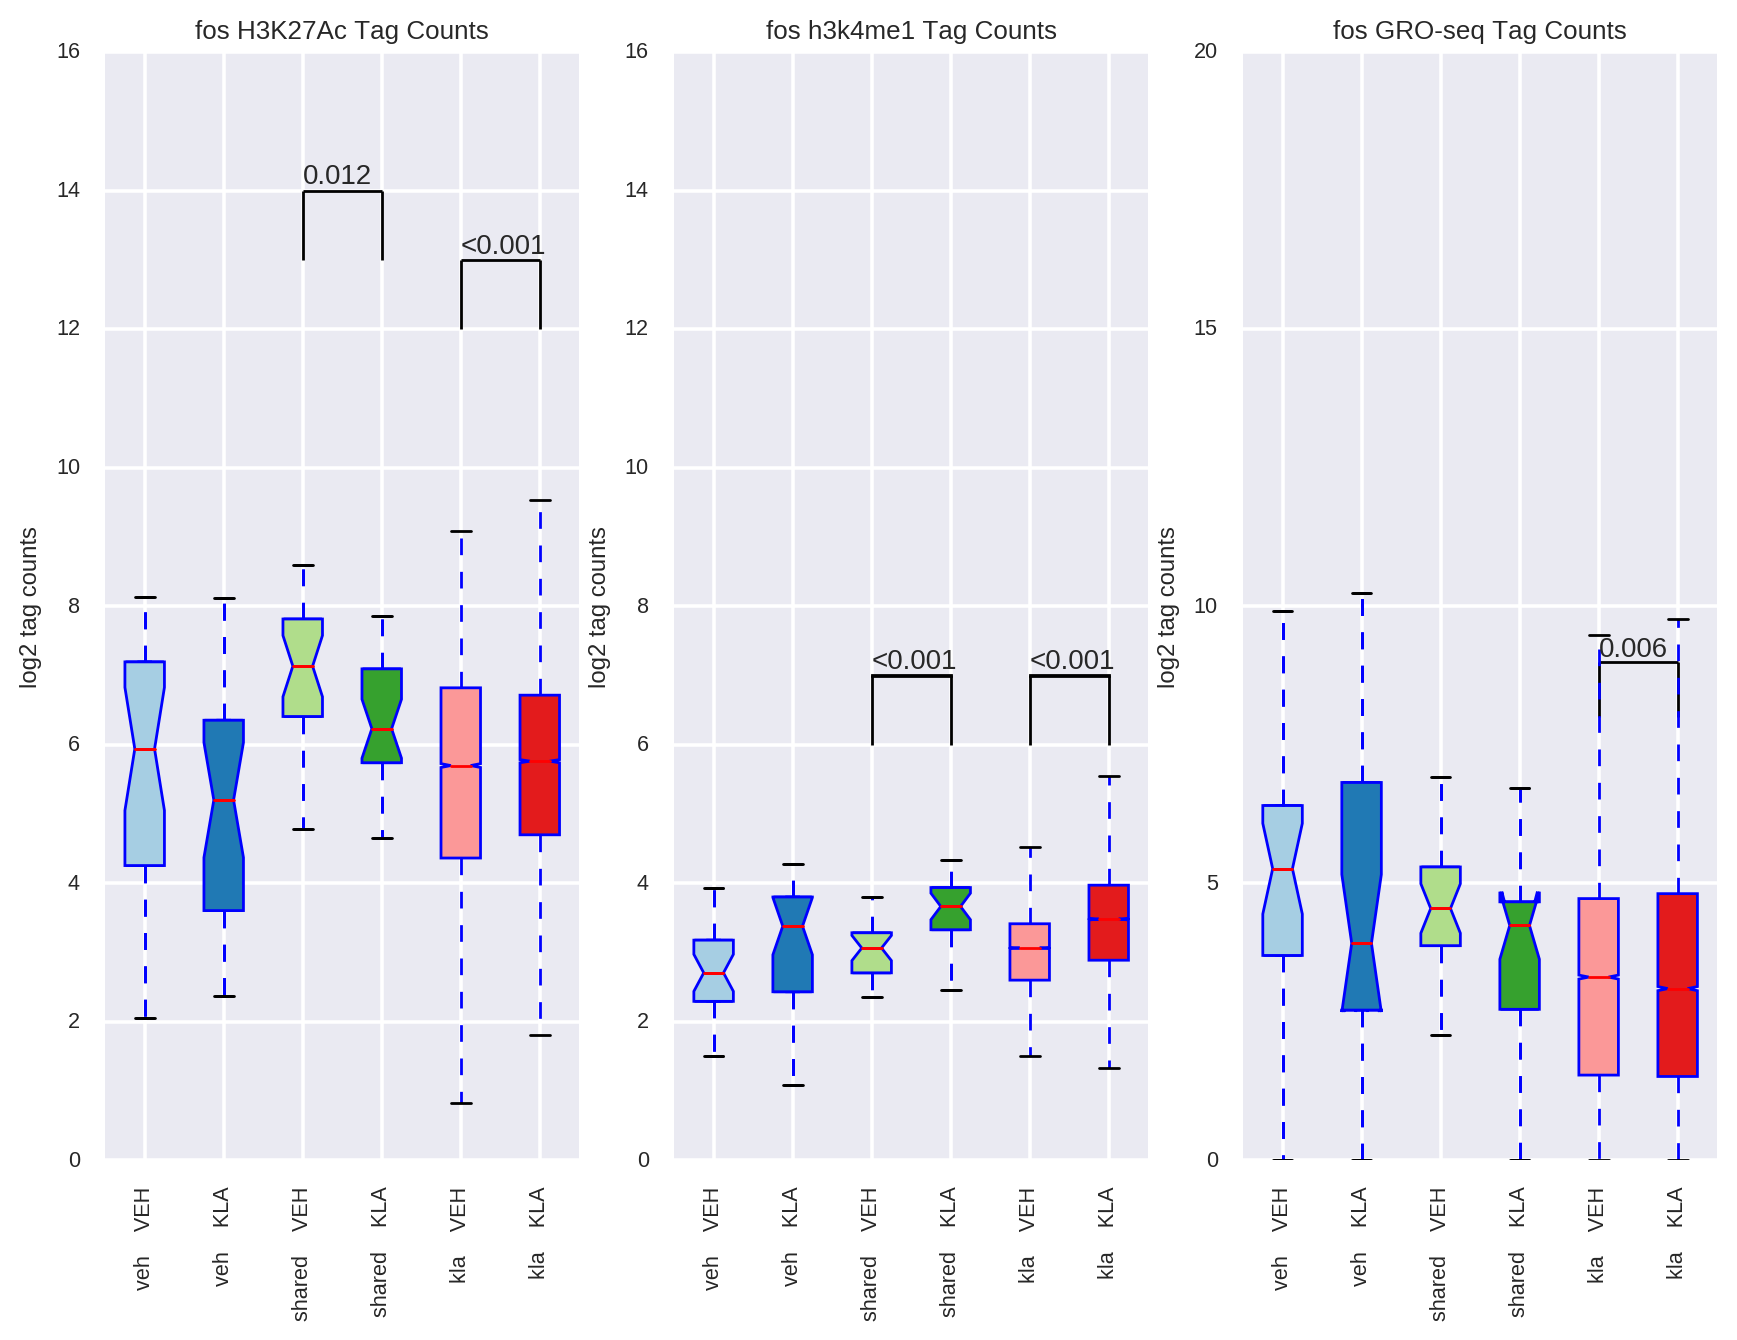

In [24]:
# plot enhancer mark boxplots
# colors = []
# for i in sns.color_palette('colorblind',8):
#     colors.append(i)
#     colors.append(i)
sns.set_context('talk', font_scale=0.6)
colors = sns.color_palette('Paired',8)
p_threshold = 0.05

for f in ['fos']:
    veh_f = f + '_veh'
    kla_f = f+ '_kla'
    veh_ids = enhancer_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] == 0)]['ID'].values
    kla_ids = summary_frame[(summary_frame[veh_f] == 0) & (summary_frame[kla_f] > 0)]['ID'].values
    shared_ids = summary_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] > 0)]['ID'].values
    id_lists = [veh_ids, shared_ids, kla_ids]
    id_names = ['veh', 'shared', 'kla']

    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,1)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        ### h3k27ac
        veh_values = enhancer_frame.ix[ids,'h3k27ac_veh'].values
        kla_values = enhancer_frame.ix[ids,'h3k27ac_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' H3K27Ac Tag Counts')
    ### for h3k4me1
    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,2)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        veh_values = enhancer_frame.ix[ids,'h3k4me1_veh'].values
        kla_values = enhancer_frame.ix[ids,'h3k4me1_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' h3k4me1 Tag Counts')
    
    # for Gro seq
    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,3)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        veh_values = enhancer_frame.ix[ids,'gro_veh'].values
        kla_values = enhancer_frame.ix[ids,'gro_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,20])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' GRO-seq Tag Counts')
    plt.show()
    plt.close()
sns.set_context('talk', font_scale=1.0)




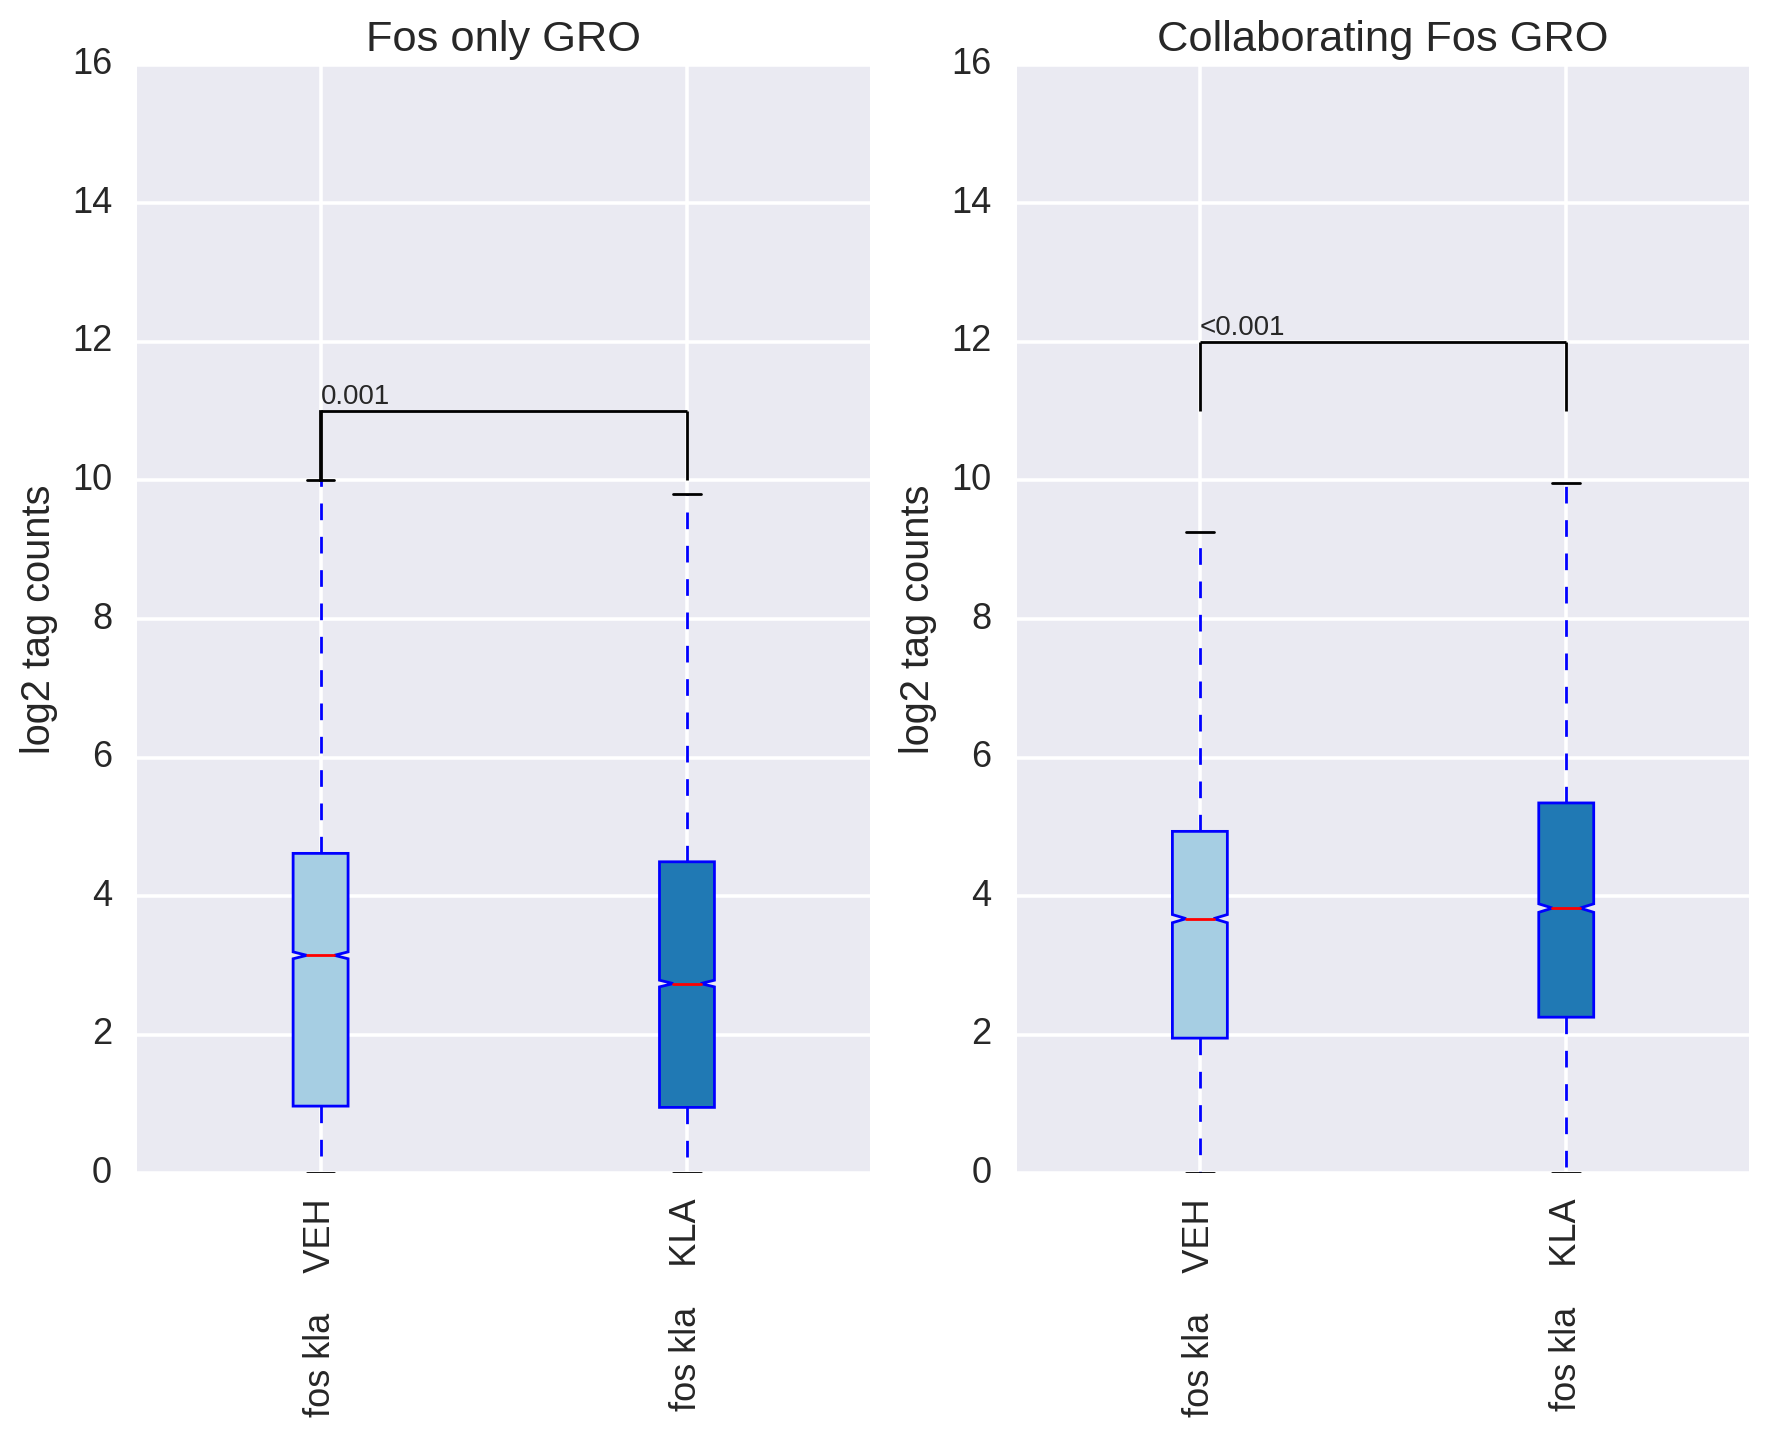

In [25]:
fos_only_ids = summary_frame[summary_frame.sum(axis=1)==summary_frame['fos_kla']]['ID'].values

counts = []
labels = []
pvals = []
plt.subplot(1,2,1)
veh_values = enhancer_frame.ix[fos_only_ids,'gro_veh'].values
kla_values = enhancer_frame.ix[fos_only_ids,'gro_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('Fos only GRO')

fos_collaborating_ids = summary_frame[(summary_frame.sum(axis=1)!=summary_frame['fos_kla']) & (summary_frame['fos_kla'] > 0)]['ID'].values
counts = []
labels = []
pvals = []
plt.subplot(1,2,2)
ids = fos_only_ids
veh_values = enhancer_frame.ix[fos_collaborating_ids,'gro_veh'].values
kla_values = enhancer_frame.ix[fos_collaborating_ids,'gro_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('Collaborating Fos GRO')


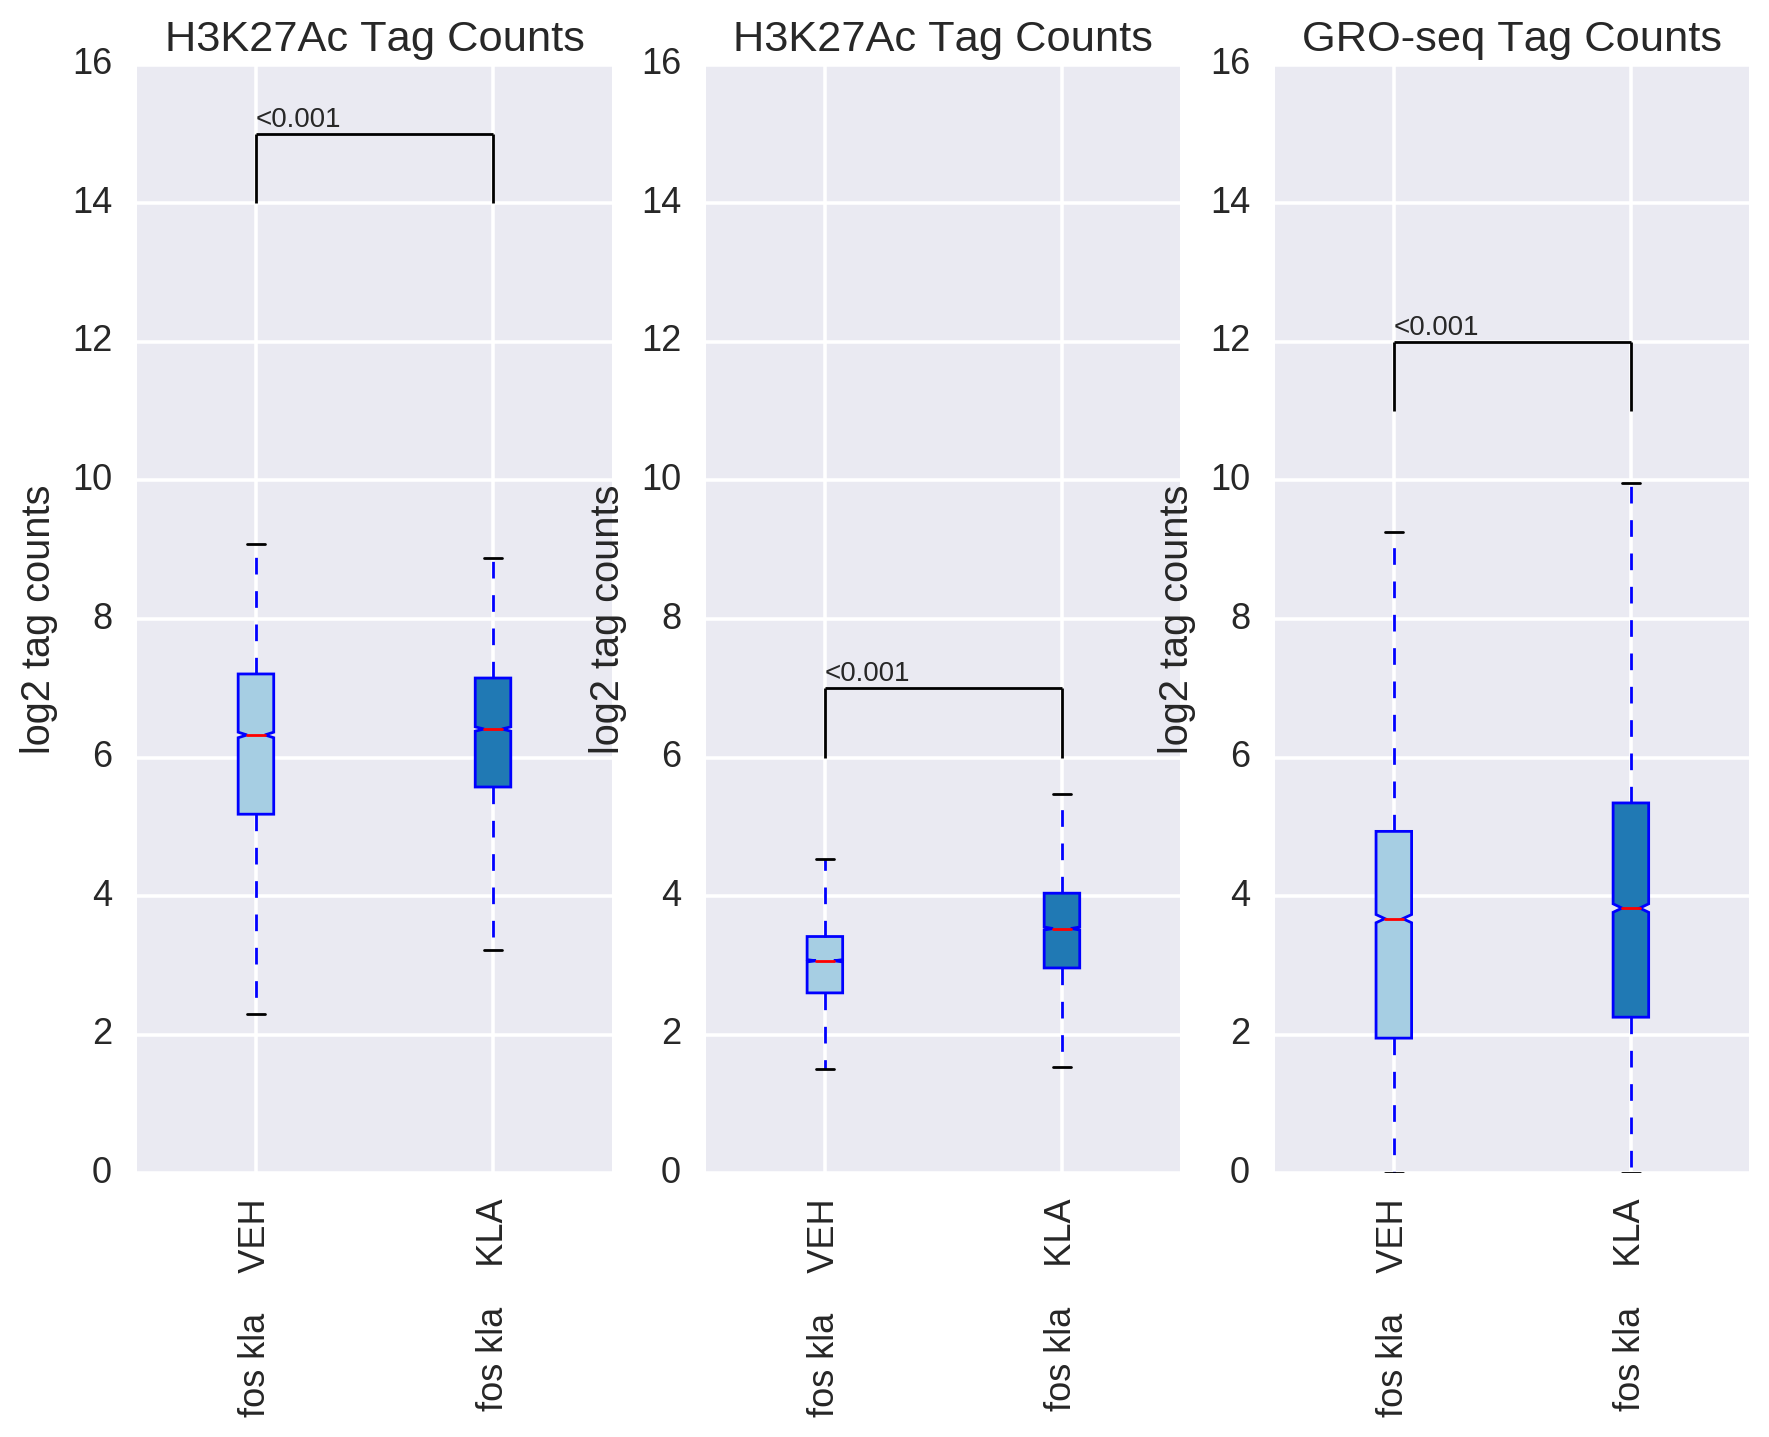

In [26]:
fos_collaborating_ids = summary_frame[(summary_frame.sum(axis=1)!=summary_frame['fos_kla']) & (summary_frame['fos_kla'] > 0)]['ID'].values

counts = []
labels = []
pvals = []
plt.subplot(1,3,1)
veh_values = enhancer_frame.ix[fos_collaborating_ids,'h3k27ac_veh'].values
kla_values = enhancer_frame.ix[fos_collaborating_ids,'h3k27ac_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('H3K27Ac Tag Counts')



counts = []
labels = []
pvals = []
plt.subplot(1,3,2)
veh_values = enhancer_frame.ix[fos_collaborating_ids,'h3k4me1_veh'].values
kla_values = enhancer_frame.ix[fos_collaborating_ids,'h3k4me1_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('H3K27Ac Tag Counts')


counts = []
labels = []
pvals = []
plt.subplot(1,3,3)
veh_values = enhancer_frame.ix[fos_collaborating_ids,'gro_veh'].values
kla_values = enhancer_frame.ix[fos_collaborating_ids,'gro_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('GRO-seq Tag Counts')



## Single Peak Calling

In [250]:
%%bash
for i in ./tag_directories/C57Bl6_Thiomac*Veh*14-03-17
do sample=${i/Thiomac_ChIP_};
sample=${sample/_GJF_14-03-17};
sample=${sample#./*/}
sample=${sample,,};
echo "findPeaks $i -i ./input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20 -o ./peak_files/${sample}_peaks.tsv -size 100 &"; 
done
for i in ./tag_directories/C57Bl6_Thiomac*KLA*14-03-17
do sample=${i/Thiomac_ChIP_};
sample=${sample/_GJF_14-03-17};
sample=${sample#./*/}
sample=${sample/-1h};
sample=${sample,,};
echo "findPeaks $i -i ./input_data/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20 -o ./peak_files/${sample}_peaks.tsv -size 100 &"; 

done

findPeaks ./tag_directories/C57Bl6_Thiomac_ChIP_cJun_Veh_GJF_14-03-17 -i ./input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20 -o ./peak_files/c57bl6_cjun_veh_peaks.tsv -size 100 &
findPeaks ./tag_directories/C57Bl6_Thiomac_ChIP_Fos_Veh_GJF_14-03-17 -i ./input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20 -o ./peak_files/c57bl6_fos_veh_peaks.tsv -size 100 &
findPeaks ./tag_directories/C57Bl6_Thiomac_ChIP_Fra1_Veh_GJF_14-03-17 -i ./input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20 -o ./peak_files/c57bl6_fra1_veh_peaks.tsv -size 100 &
findPeaks ./tag_directories/C57Bl6_Thiomac_ChIP_Fra2_Veh_GJF_14-03-17 -i ./input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20 -o ./peak_files/c57bl6_fra2_veh_peaks.tsv -size 100 &
findPeaks ./tag_directories/C57Bl6_Thiomac_ChIP_Jdp2_Veh_GJF_14-03-17 -i ./input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20 -o ./peak_files/c57bl6_jdp2_veh_peaks.tsv -size 100 &
findPeaks ./tag_directories/C57Bl6_Thiomac_ChIP_JunB_Veh_GJF_14-03-17 -i ./input_data/C

c57bl6_cjun_kla_peaks.tsv
c57bl6_cjun_veh_peaks.tsv
c57bl6_fos_kla_peaks.tsv
c57bl6_fos_veh_peaks.tsv
c57bl6_fra1_kla_peaks.tsv
c57bl6_fra1_veh_peaks.tsv
c57bl6_fra2_kla_peaks.tsv
c57bl6_fra2_veh_peaks.tsv
c57bl6_junb_kla_peaks.tsv
c57bl6_junb_veh_peaks.tsv
c57bl6_jund_kla_peaks.tsv
c57bl6_jund_veh_peaks.tsv


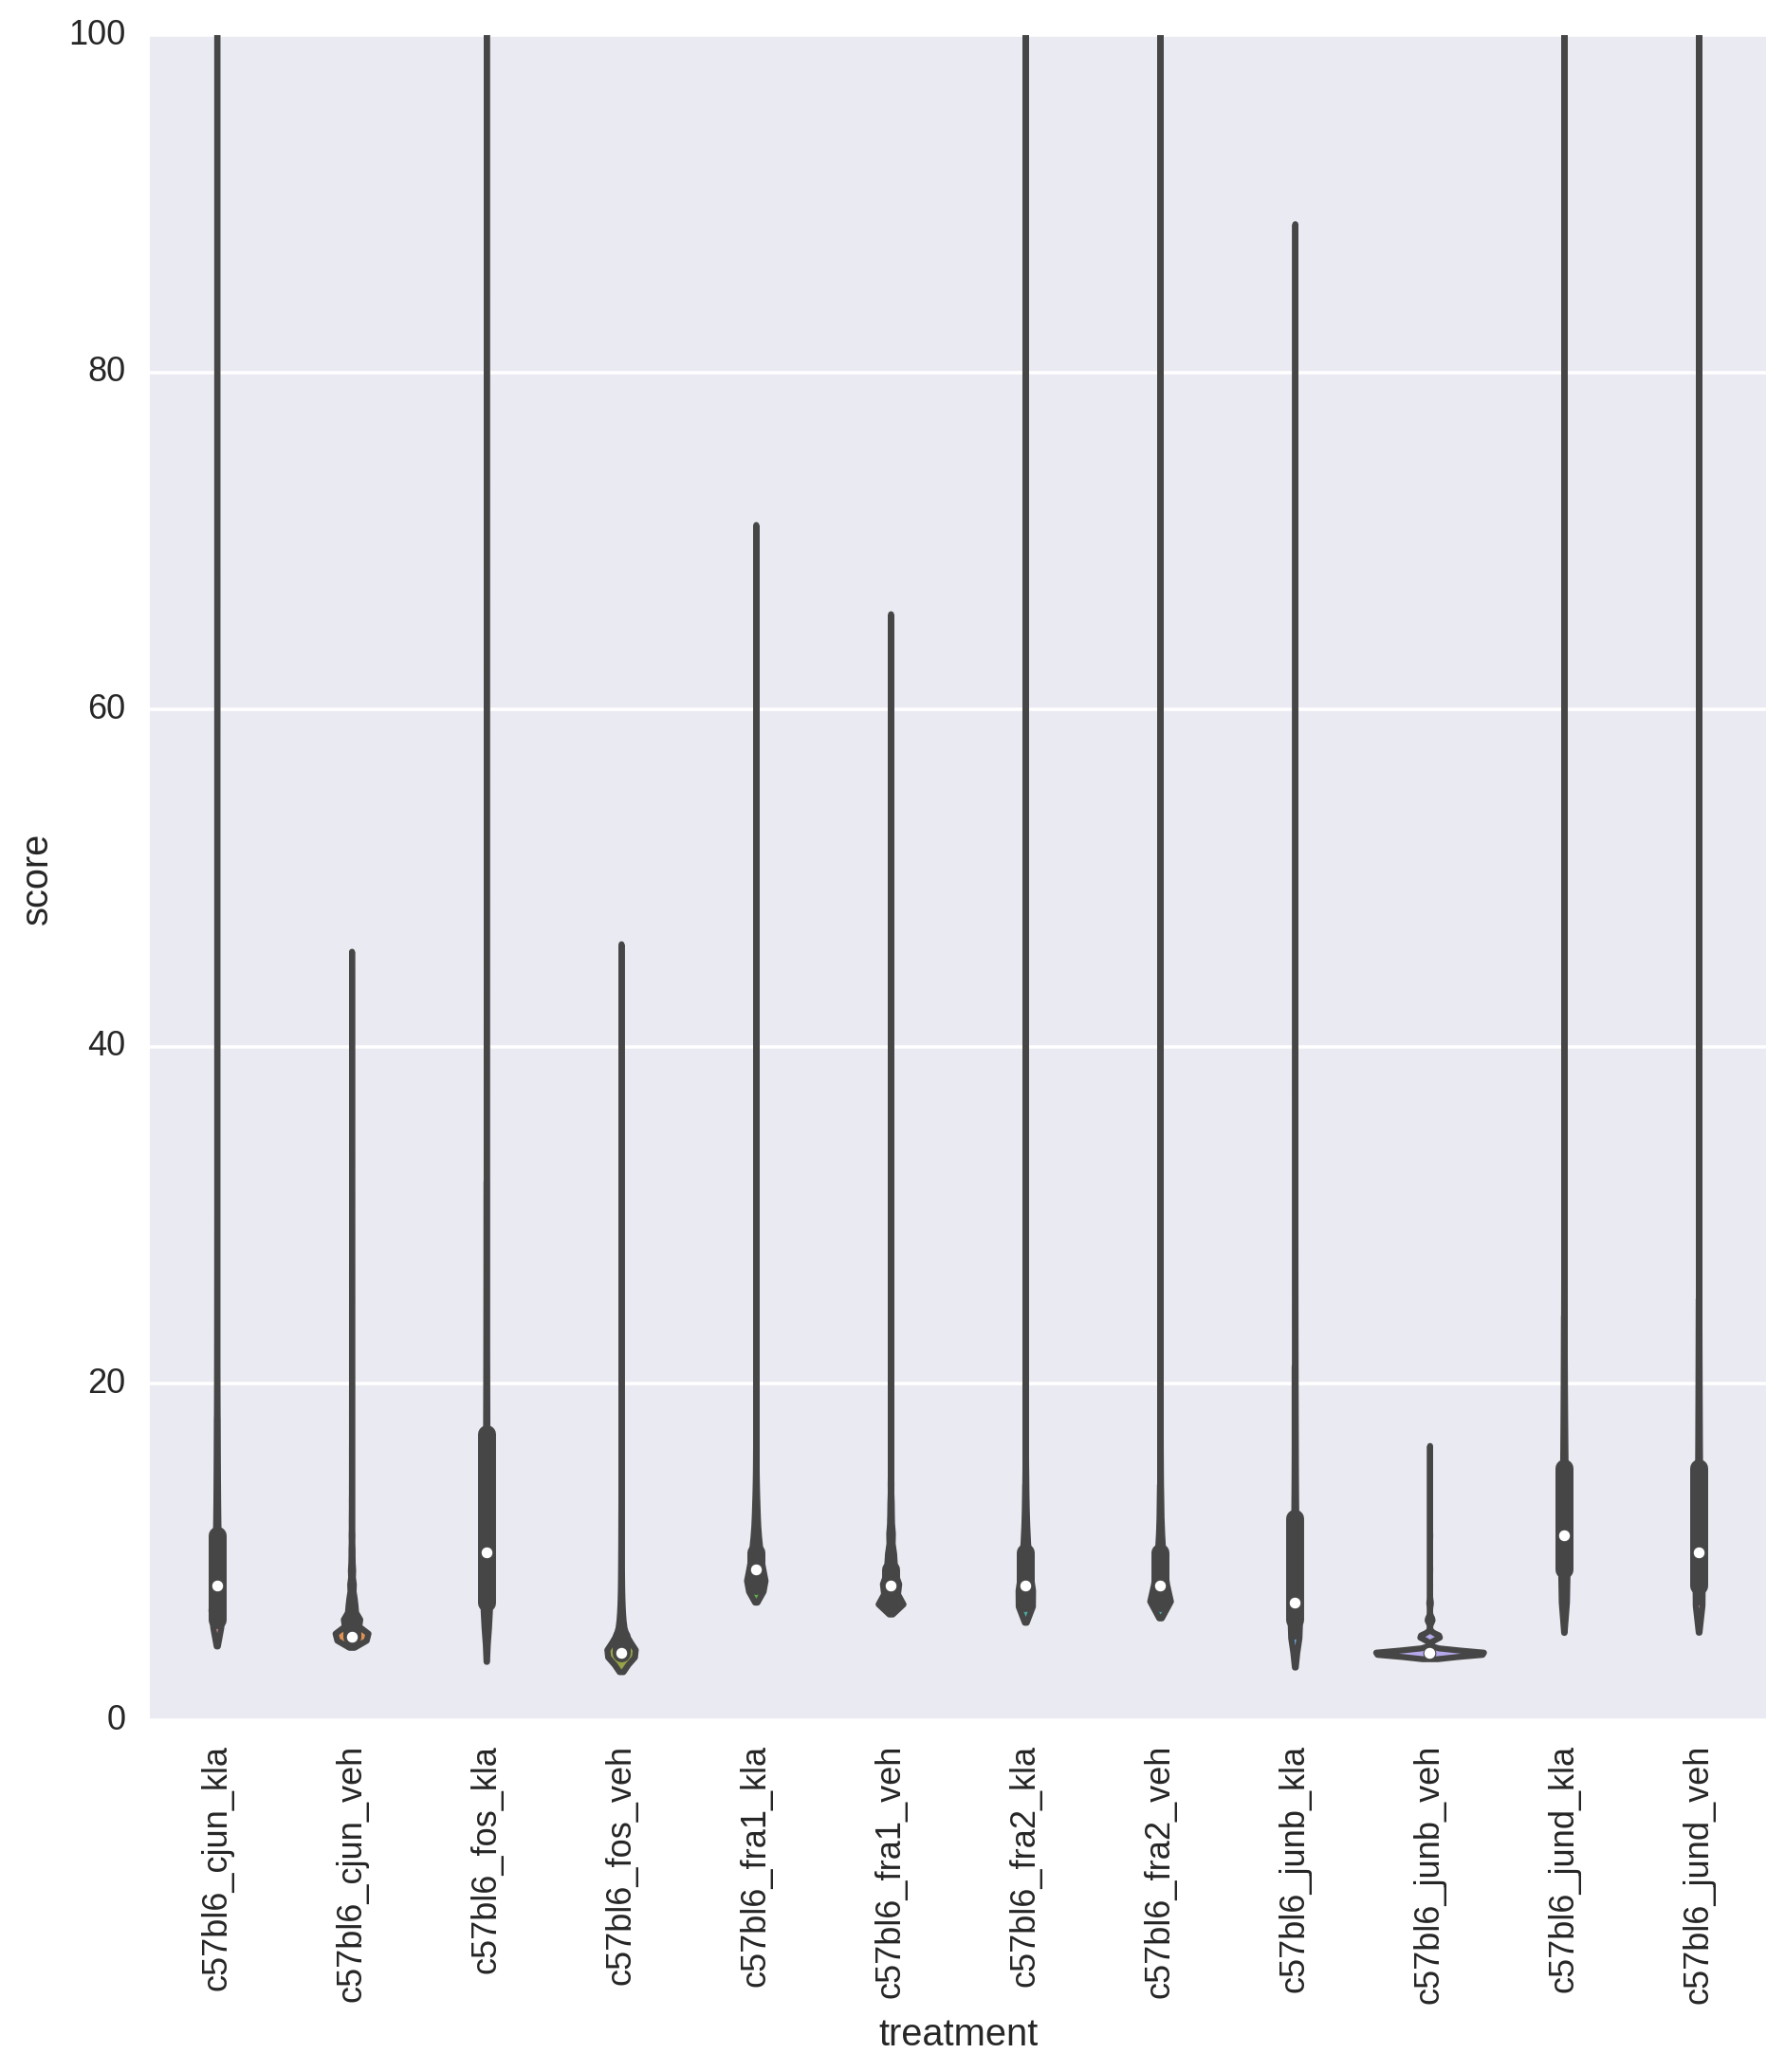

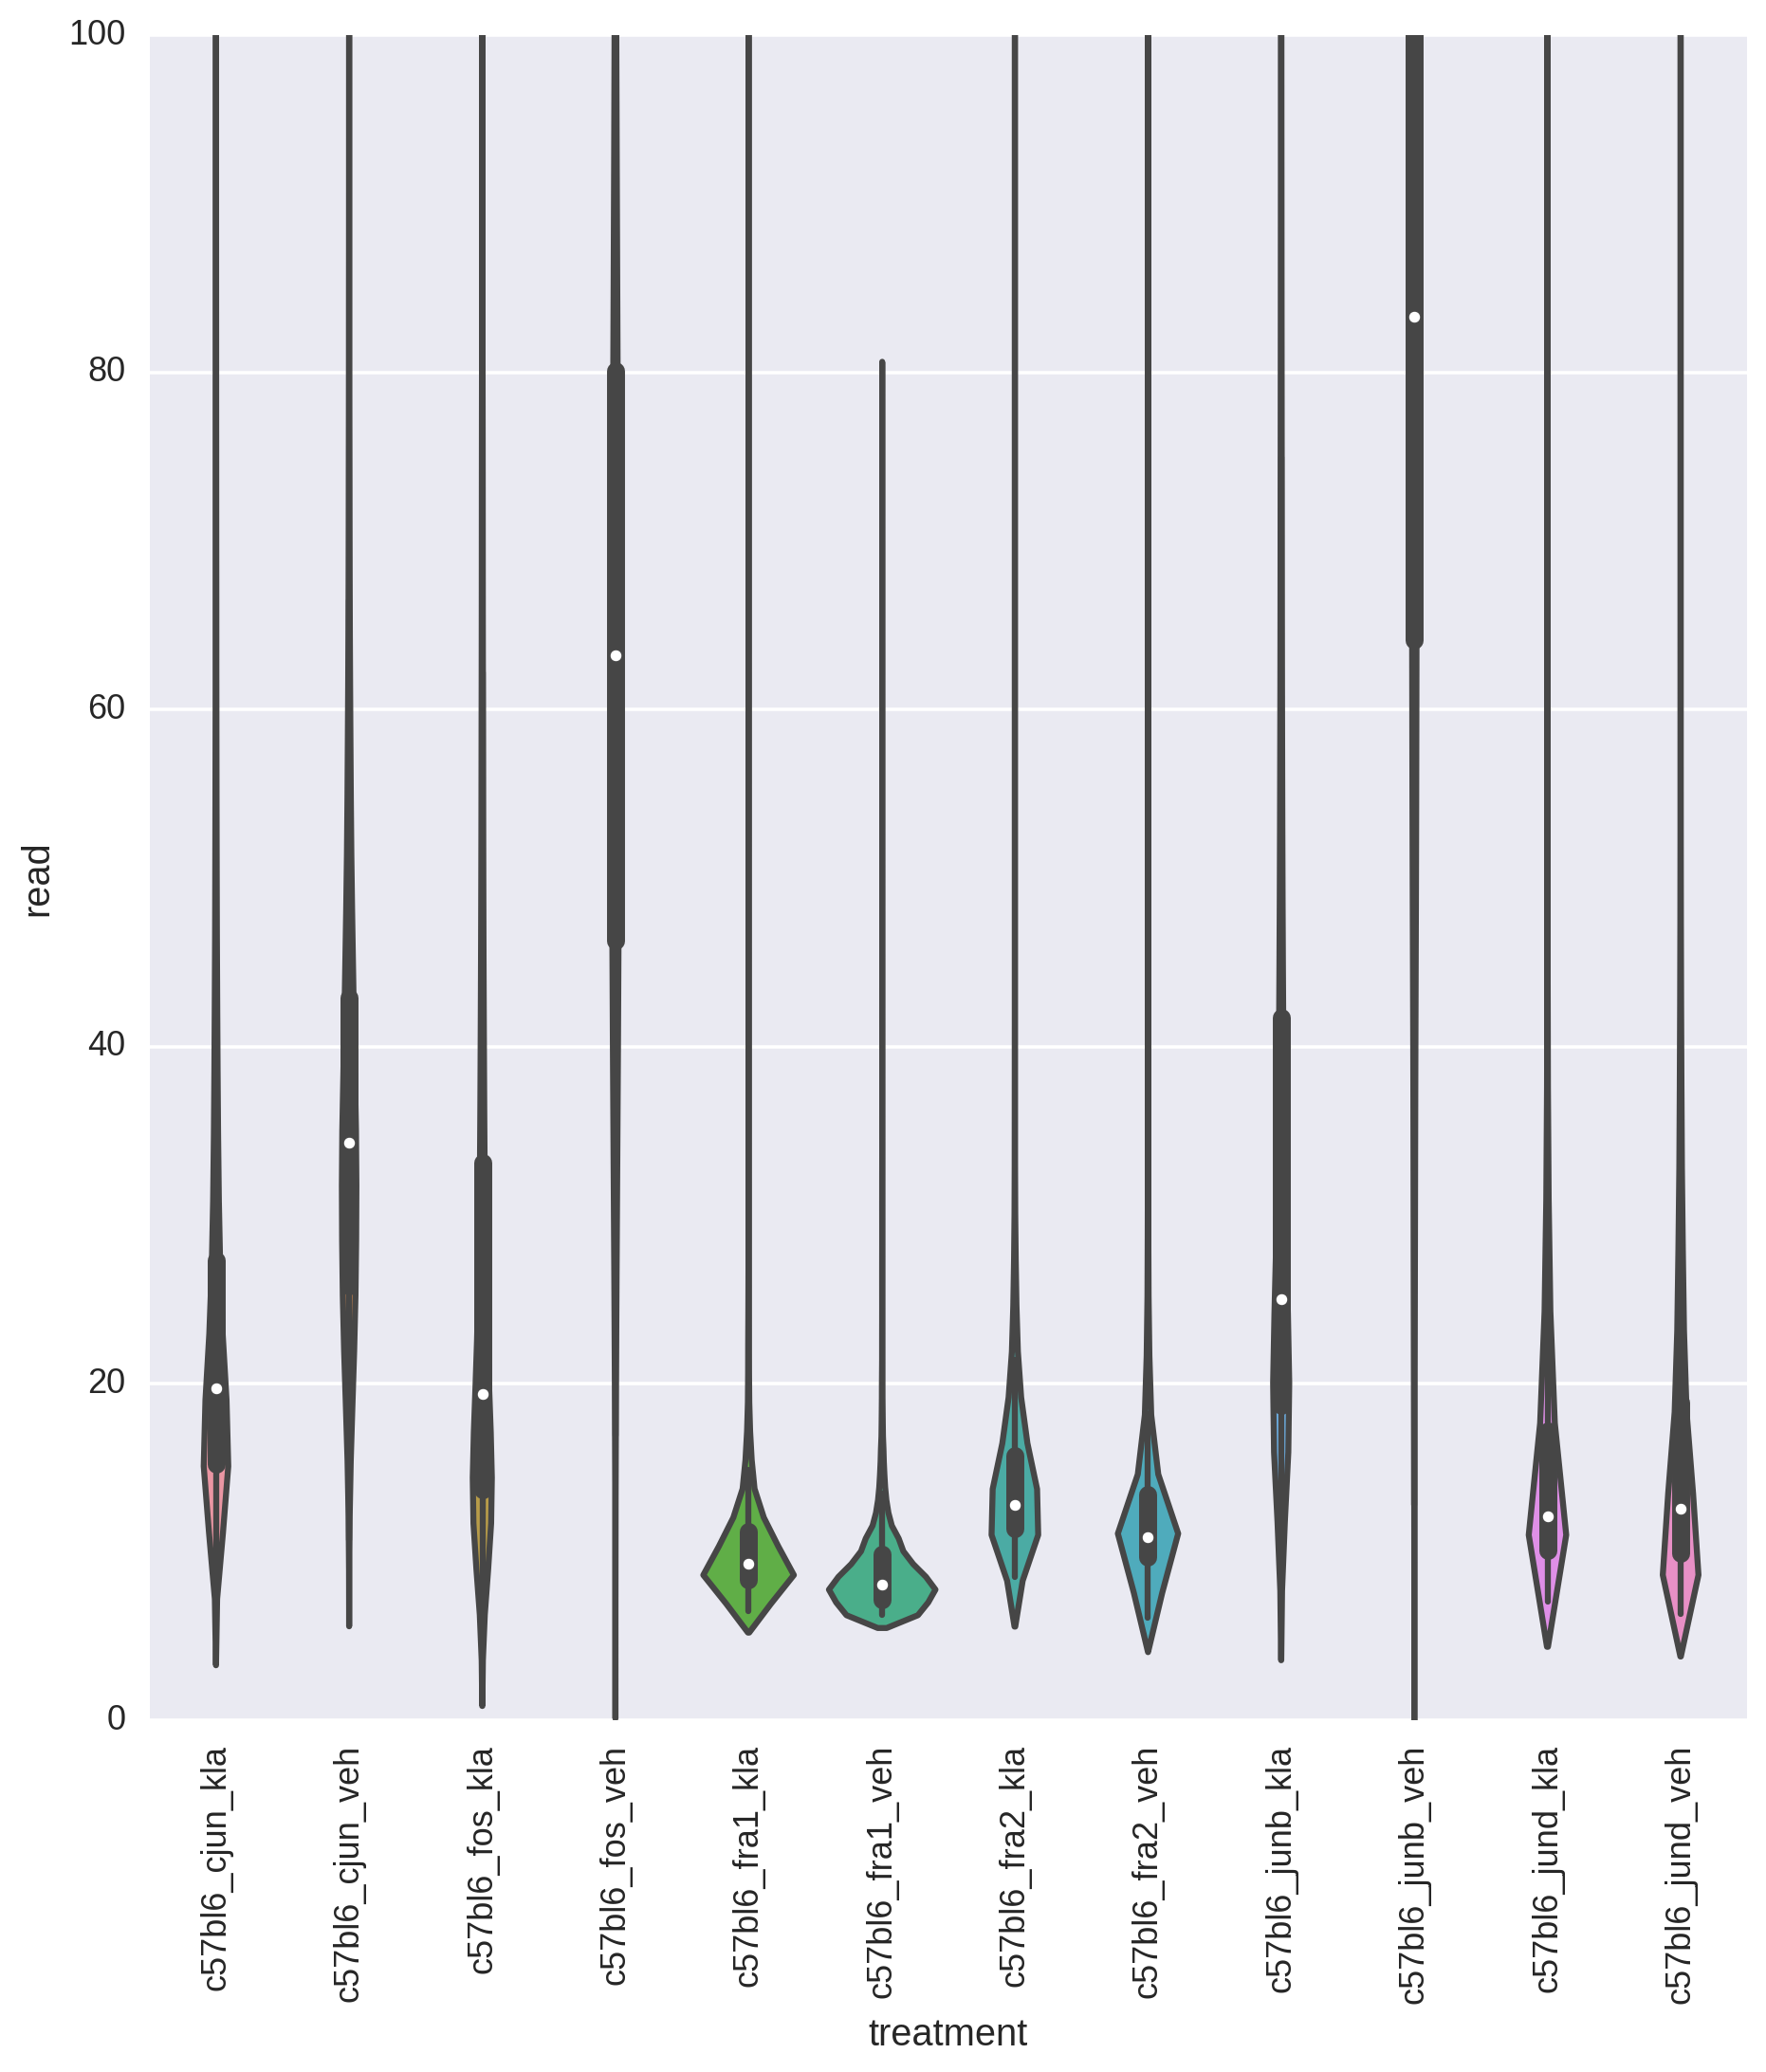

In [240]:
os.chdir(workingDirectory)
treatments = []
scores = []
reads = []
! if [ ! -d ./peak_files_strains_filtered ]; then mkdir ./peak_files_strains_filtered; fi
for i in sorted(os.listdir('./peak_files/')):
    print(i)
    frame = pd.read_csv('./peak_files/' + i, skiprows=38, sep='\t')
    treatments = treatments + [i.replace('_peaks.tsv','')] * frame.shape[0]
    scores = scores + list(frame['findPeaks Score'].values)
    reads = reads + list(frame['Normalized Tag Count'].values)
#     reads = reads + list(frame.ix[:,8].values)


plottingFrame = pd.DataFrame({'treatment': treatments,
                              'score':scores,
                               'read':reads})
sns.factorplot(data=plottingFrame, 
                x='treatment',
               y='score',
               kind='violin',
              size=10)
plt.xticks(rotation=90)
plt.ylim(0,100)


plt.show()
sns.factorplot(data=plottingFrame, 
                x='treatment',
               y='read',
               kind='violin',
              size=10)
plt.ylim(0,100)
plt.xticks(rotation=90)
plt.show()

In [253]:
! if [ ! -d ./peak_files_strains_filtered ]; then mkdir ./peak_files_strains_filtered; fi
for i in sorted(os.listdir('./peak_files/')):
    frame = pd.read_csv('./peak_files/' + i, skiprows=38, sep='\t')
    
#     filtered_frame = frame[frame['Normalized Tag Count'] > np.percentile(frame['Normalized Tag Count'], 50)]
    filtered_frame = frame[frame['Normalized Tag Count'] >= 16]
#     filtered_frame = frame[frame['findPeaks Score'] >= 10]

    filtered_frame.to_csv('./peak_files_filtered/' + i, index=False, sep='\t')
    print(i, filtered_frame.shape[0])
    

c57bl6_atf3_kla_peaks.tsv 0
c57bl6_atf3_veh_peaks.tsv 1050
c57bl6_cjun_kla_peaks.tsv 18435
c57bl6_cjun_veh_peaks.tsv 13585
c57bl6_fos_kla_peaks.tsv 29339
c57bl6_fos_veh_peaks.tsv 6805
c57bl6_fra1_kla_peaks.tsv 306
c57bl6_fra1_veh_peaks.tsv 389
c57bl6_fra2_kla_peaks.tsv 1303
c57bl6_fra2_veh_peaks.tsv 1518
c57bl6_junb_kla_peaks.tsv 27304
c57bl6_junb_veh_peaks.tsv 2826
c57bl6_jund_kla_peaks.tsv 9933
c57bl6_jund_veh_peaks.tsv 15886


## Strains Peak Files Calling 

In [332]:
os.chdir('/home/jenhan/analysis/ap1_analysis/tag_directories_strains/')

In [333]:
%%bash
for i in ./Balbc_Thiomac_ChIP_*Veh*; 
do sample=${i/Thiomac_ChIP_};
sample=${sample/_GFEW_10-19-15};
sample=${sample,,};
# echo findPeaks $i -i Balbc_Thiomac_ChIP_Input_Veh_GFEW_10-19-15/ -o ${sample}_peaks.tsv -size 100; 
echo "findPeaks $i -i Balbc_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ${sample}_peaks.tsv -size 200 &"; 
# findPeaks $i -i Balbc_Thiomac_ChIP_Input_Veh_GFEW_10-19-15/ -o ${sample}_peaks.tsv -size 100; 
# findPeaks $i -i Balbc_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ${sample}_peaks.tsv -size 100; 
done
for i in ./Balbc_Thiomac_ChIP_*KLA*; 
do sample=${i/Thiomac_ChIP_};
sample=${sample/_GFEW_10-19-15};
sample=${sample/-1h};
sample=${sample,,};
echo "findPeaks $i -i Balbc_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ${sample}_peaks.tsv -size 200 &"; 
# findPeaks $i -i Balbc_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ${sample}_peaks.tsv -size 100; 
done

findPeaks ./Balbc_Thiomac_ChIP_cJun_Veh_GFEW_10-19-15 -i Balbc_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ./balbc_cjun_veh_peaks.tsv -size 200 &
findPeaks ./Balbc_Thiomac_ChIP_Fos_Veh_GFEW_10-19-15 -i Balbc_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ./balbc_fos_veh_peaks.tsv -size 200 &
findPeaks ./Balbc_Thiomac_ChIP_Input_Veh_GFEW_10-19-15 -i Balbc_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ./balbc_input_veh_peaks.tsv -size 200 &
findPeaks ./Balbc_Thiomac_ChIP_Jdp2_Veh_GFEW_10-19-15 -i Balbc_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ./balbc_jdp2_veh_peaks.tsv -size 200 &
findPeaks ./Balbc_Thiomac_ChIP_JunB_Veh_GFEW_10-19-15 -i Balbc_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ./balbc_junb_veh_peaks.tsv -size 200 &
findPeaks ./Balbc_Thiomac_ChIP_JunD_Veh_GFEW_10-19-15 -i Balbc_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ./balbc_jund_veh_peaks.tsv -size 200 &
findPeaks ./Balbc_Thiomac_ChIP_PU1_Veh_GFEW_10-19-15 -i Balbc_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ./balbc_pu1_veh_pe

In [334]:
%%bash
for i in ./NOD_Thiomac_ChIP_*Veh*; 
do sample=${i/Thiomac_ChIP_};
sample=${sample/_GFEW_10-19-15};
sample=${sample,,};
echo "findPeaks $i -i NOD_Thiomac_ChIP_Input_Veh_GFEW_10-19-15/ -o ${sample}_peaks.tsv -size 200 &"; 
# findPeaks $i -i NOD_Thiomac_ChIP_Input_Veh_GFEW_10-19-15/ -o ${sample}_peaks.tsv -size 100; 
done
for i in ./NOD_Thiomac_ChIP_*KLA*; 
do sample=${i/Thiomac_ChIP_};
sample=${sample/_GFEW_10-19-15};
sample=${sample/-1h};
sample=${sample,,};
echo "findPeaks $i -i NOD_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ${sample}_peaks.tsv -size 200 &"; 
# findPeaks $i -i NOD_Thiomac_ChIP_Input_KLA-1h_GFEW_10-19-15/ -o ${sample}_peaks.tsv -size 100; 
done

findPeaks ./NOD_Thiomac_ChIP_cJun_Veh_GFEW_10-19-15 -i NOD_Thiomac_ChIP_Input_Veh_GFEW_10-19-15/ -o ./nod_cjun_veh_peaks.tsv -size 200 &
findPeaks ./NOD_Thiomac_ChIP_Fos_Veh_GFEW_10-19-15 -i NOD_Thiomac_ChIP_Input_Veh_GFEW_10-19-15/ -o ./nod_fos_veh_peaks.tsv -size 200 &
findPeaks ./NOD_Thiomac_ChIP_Input_Veh_GFEW_10-19-15 -i NOD_Thiomac_ChIP_Input_Veh_GFEW_10-19-15/ -o ./nod_input_veh_peaks.tsv -size 200 &
findPeaks ./NOD_Thiomac_ChIP_Jdp2_Veh_GFEW_10-19-15 -i NOD_Thiomac_ChIP_Input_Veh_GFEW_10-19-15/ -o ./nod_jdp2_veh_peaks.tsv -size 200 &
findPeaks ./NOD_Thiomac_ChIP_JunB_Veh_GFEW_10-19-15 -i NOD_Thiomac_ChIP_Input_Veh_GFEW_10-19-15/ -o ./nod_junb_veh_peaks.tsv -size 200 &
findPeaks ./NOD_Thiomac_ChIP_JunD_Veh_GFEW_10-19-15 -i NOD_Thiomac_ChIP_Input_Veh_GFEW_10-19-15/ -o ./nod_jund_veh_peaks.tsv -size 200 &
findPeaks ./NOD_Thiomac_ChIP_PU1_Veh_GFEW_10-19-15 -i NOD_Thiomac_ChIP_Input_Veh_GFEW_10-19-15/ -o ./nod_pu1_veh_peaks.tsv -size 200 &
findPeaks ./NOD_Thiomac_ChIP_cJun_KLA-1h_GF

In [335]:
%%bash
rm *input*peaks*tsv
rm *jdp2*peaks*tsv
rm /home/jenhan/analysis/ap1_analysis/peak_files_strains/*
mv *peaks.tsv /home/jenhan/analysis/ap1_analysis/peak_files_strains/

balbc_cjun_kla_peaks.tsv
balbc_cjun_veh_peaks.tsv
balbc_fos_kla_peaks.tsv
balbc_fos_veh_peaks.tsv
balbc_junb_kla_peaks.tsv
balbc_junb_veh_peaks.tsv
balbc_jund_kla_peaks.tsv
balbc_jund_veh_peaks.tsv
balbc_pu1_kla_peaks.tsv
balbc_pu1_veh_peaks.tsv
nod_cjun_kla_peaks.tsv
nod_cjun_veh_peaks.tsv
nod_fos_kla_peaks.tsv
nod_fos_veh_peaks.tsv
nod_junb_kla_peaks.tsv
nod_junb_veh_peaks.tsv
nod_jund_kla_peaks.tsv
nod_jund_veh_peaks.tsv
nod_pu1_kla_peaks.tsv
nod_pu1_veh_peaks.tsv


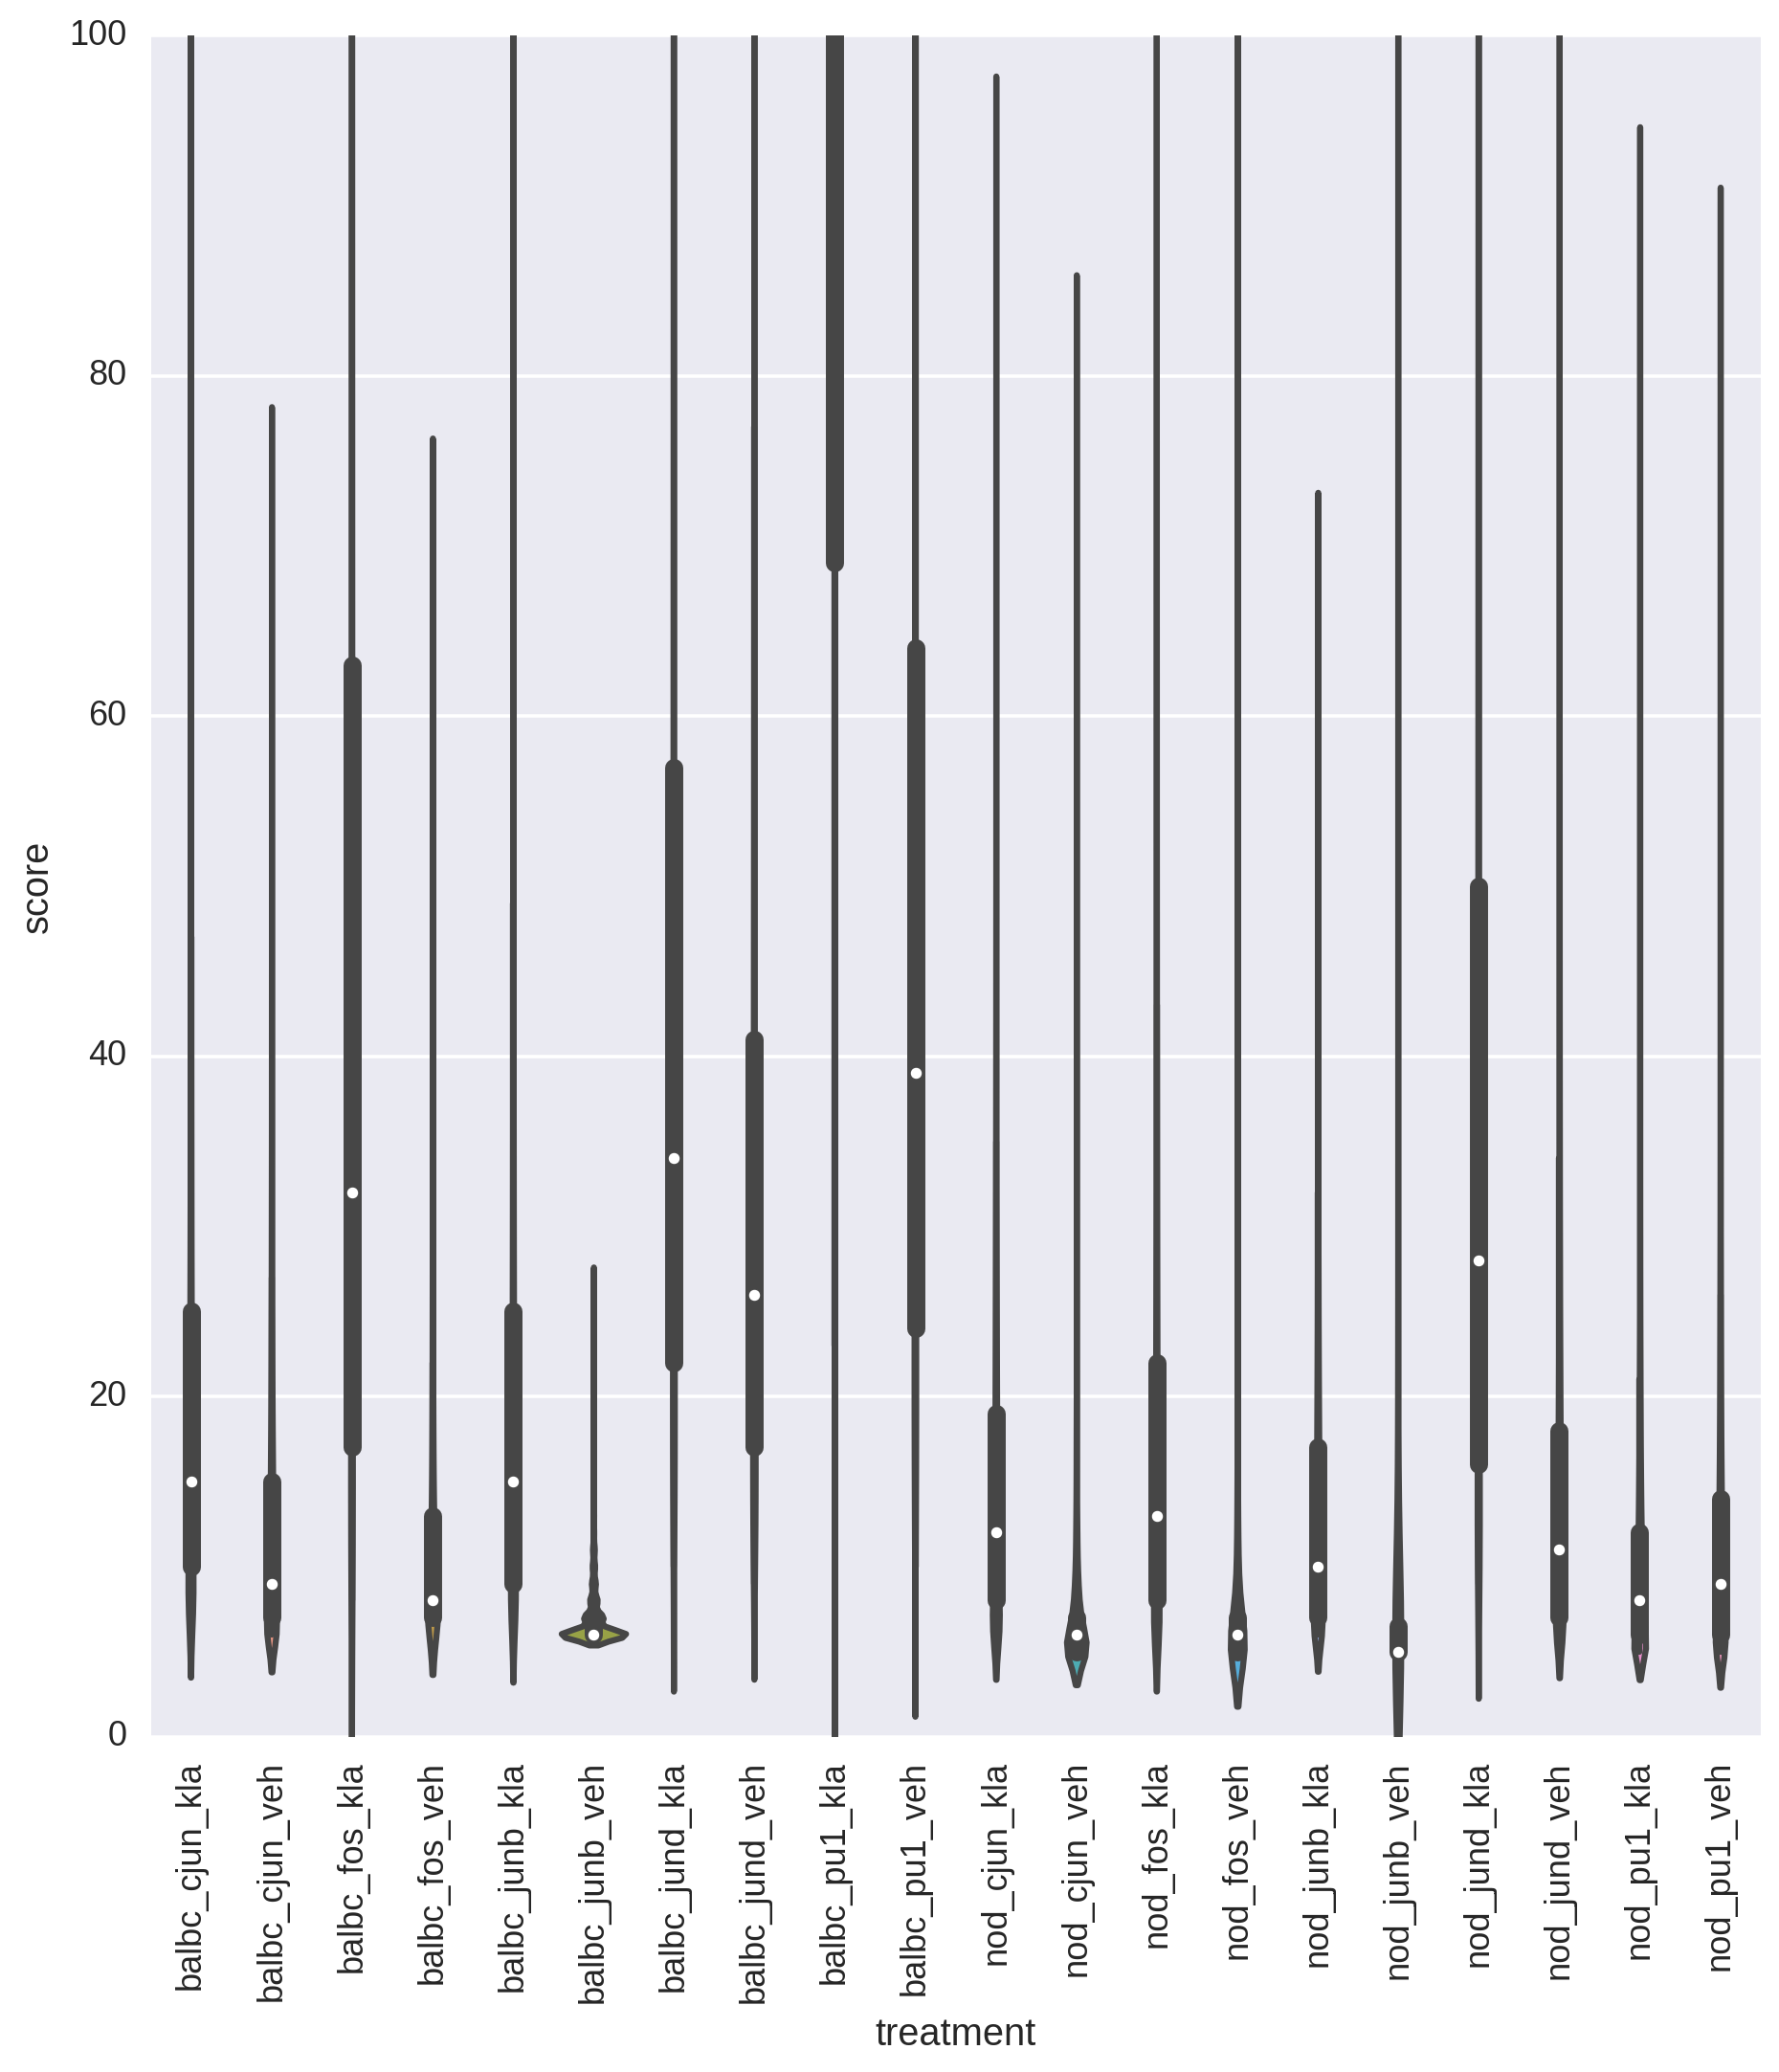

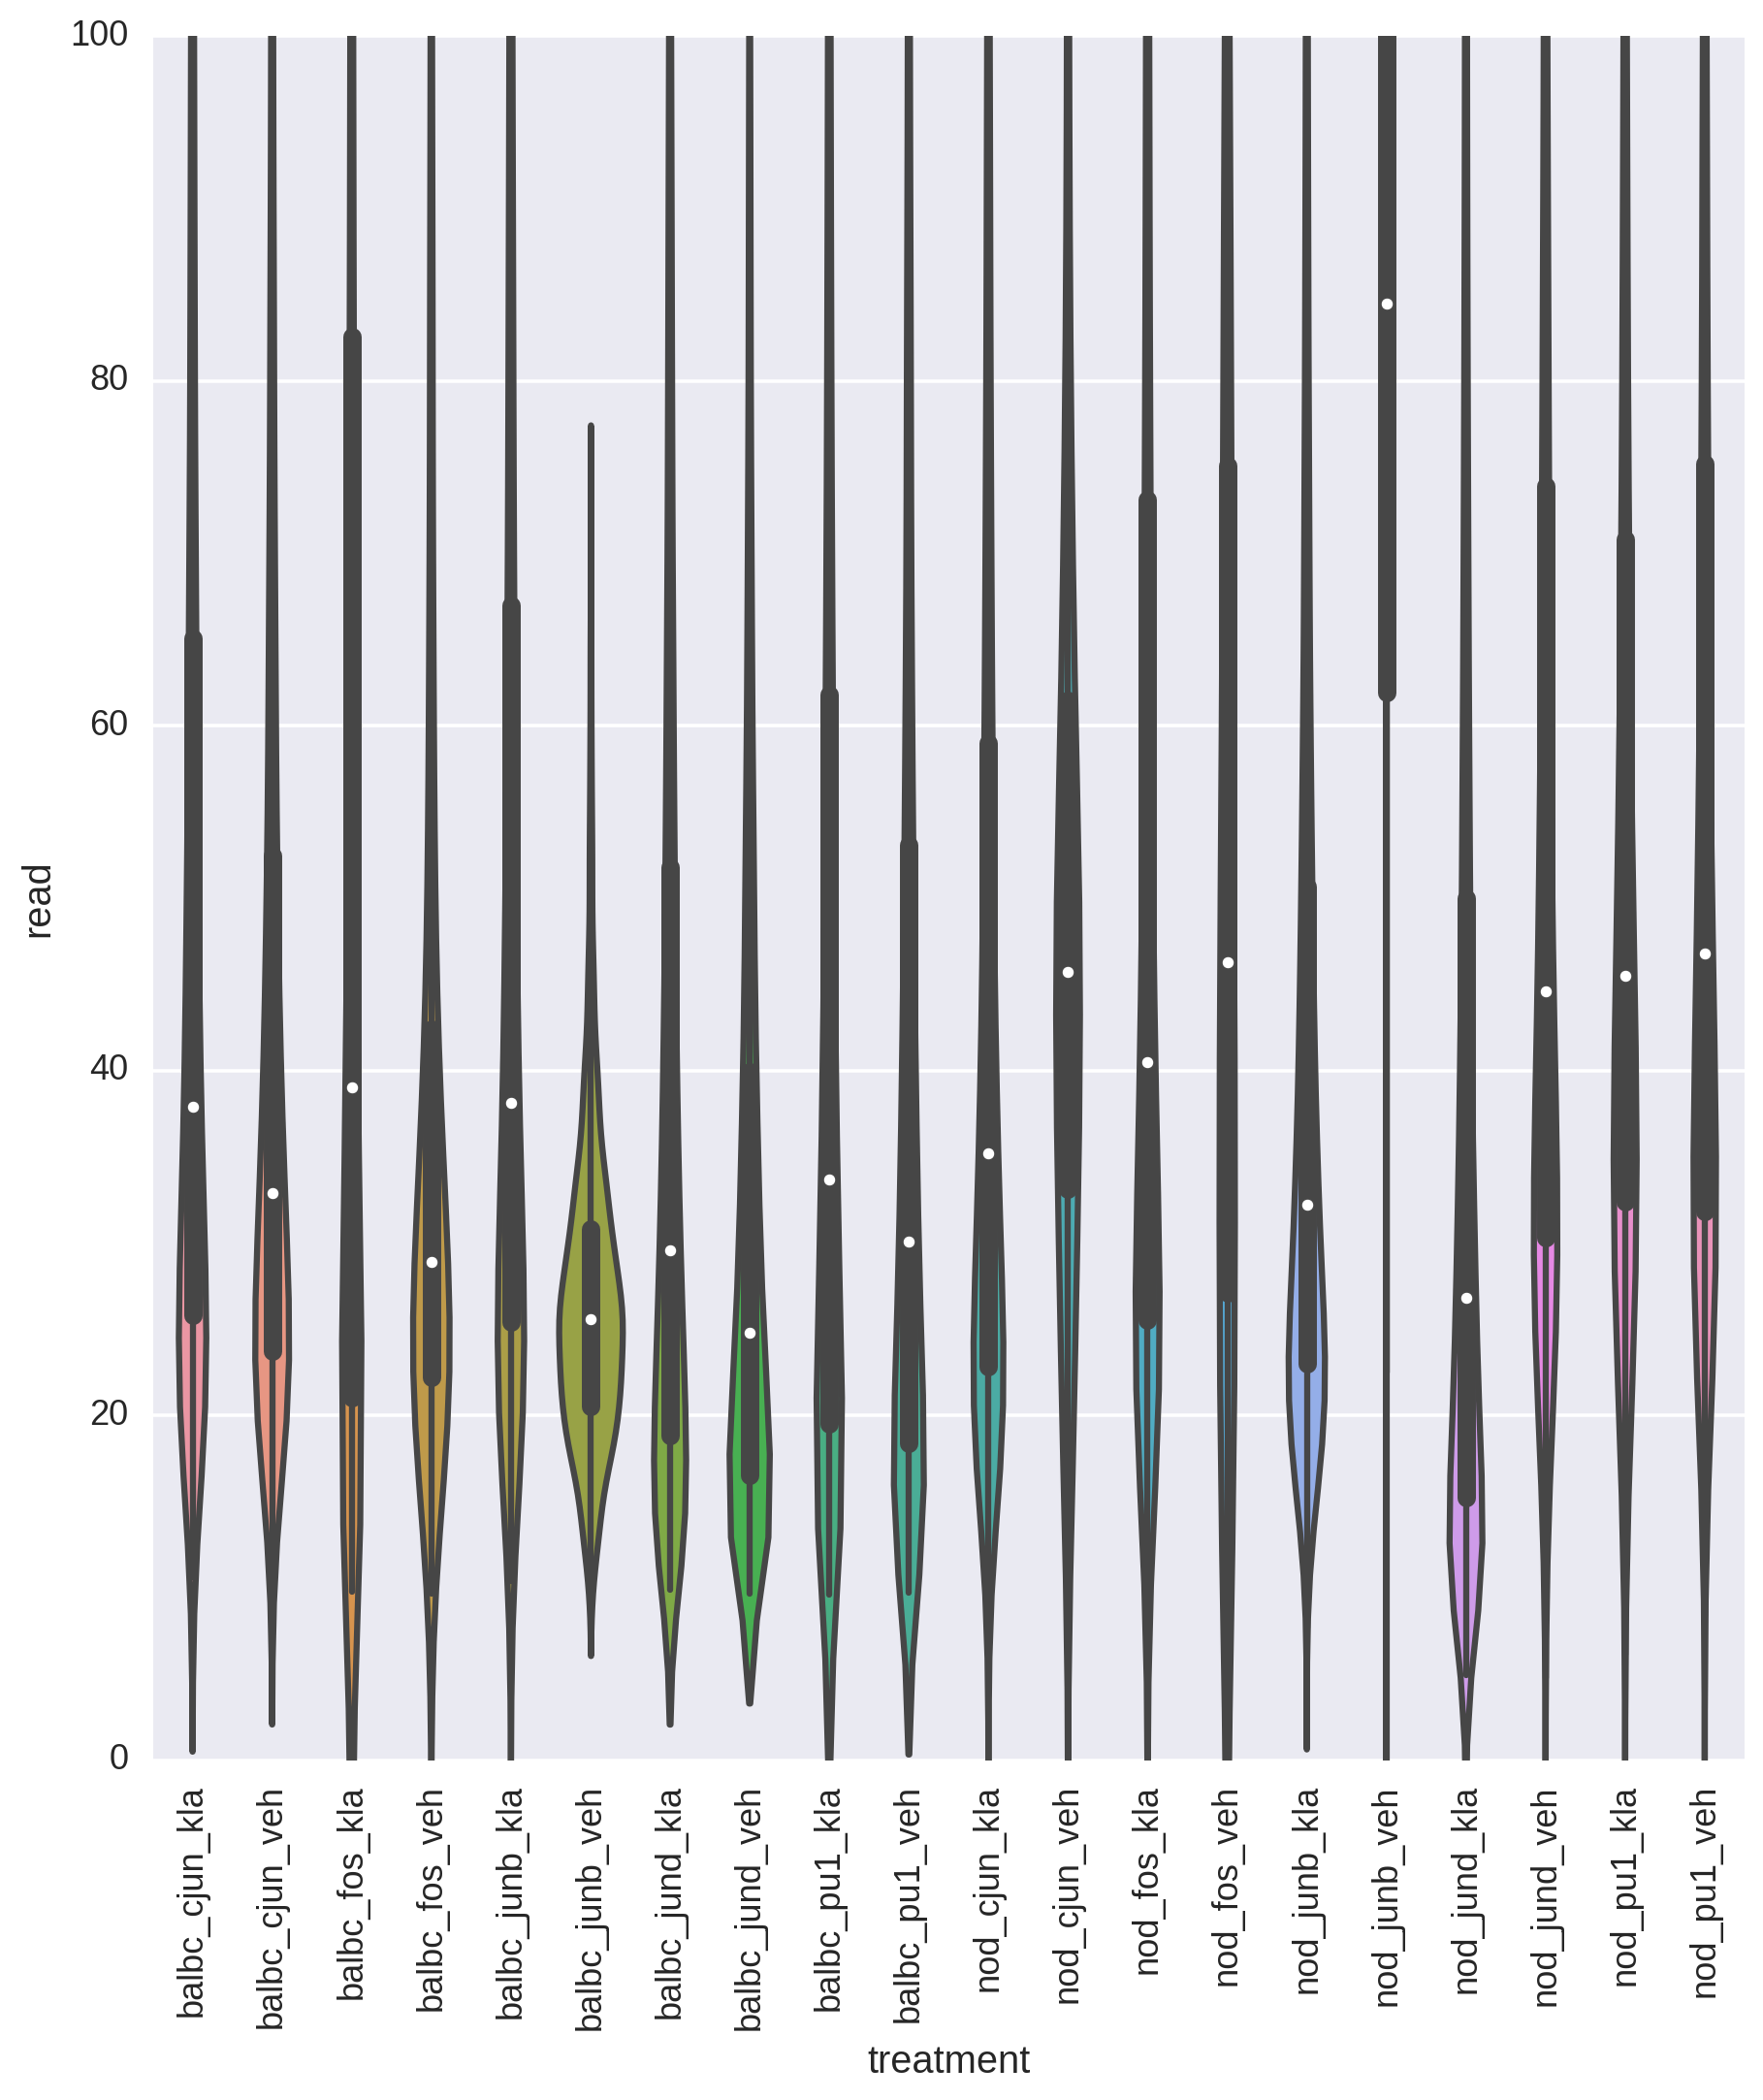

In [336]:
os.chdir(workingDirectory)
treatments = []
scores = []
reads = []
! if [ ! -d ./peak_files_strains_filtered ]; then mkdir ./peak_files_strains_filtered; fi
for i in sorted(os.listdir('./peak_files_strains/')):
    print(i)
    frame = pd.read_csv('./peak_files_strains/' + i, skiprows=38, sep='\t')
    treatments = treatments + [i.replace('_peaks.tsv','')] * frame.shape[0]
    scores = scores + list(frame['findPeaks Score'].values)
    reads = reads + list(frame['Normalized Tag Count'].values)
#     reads = reads + list(frame.ix[:,8].values)


plottingFrame = pd.DataFrame({'treatment': treatments,
                              'score':scores,
                               'read':reads})
sns.factorplot(data=plottingFrame, 
                x='treatment',
               y='score',
               kind='violin',
              size=10)
plt.xticks(rotation=90)
plt.ylim(0,100)


plt.show()
sns.factorplot(data=plottingFrame, 
                x='treatment',
               y='read',
               kind='violin',
              size=10)
plt.ylim(0,100)
plt.xticks(rotation=90)
plt.show()

In [337]:
! if [ ! -d ./peak_files_strains_filtered ]; then mkdir ./peak_files_strains_filtered; fi
for i in sorted(os.listdir('./peak_files_strains/')):
    frame = pd.read_csv('./peak_files_strains/' + i, skiprows=38, sep='\t')
    
#     filtered_frame = frame[frame['Normalized Tag Count'] > np.percentile(frame['Normalized Tag Count'], 50)]
    filtered_frame = frame[frame['Normalized Tag Count'] >= 16]
    filtered_frame.to_csv('./peak_files_strains_filtered/' + i, index=False, sep='\t')
    print(i, filtered_frame.shape[0])
    

balbc_cjun_kla_peaks.tsv 29800
balbc_cjun_veh_peaks.tsv 17969
balbc_fos_kla_peaks.tsv 44787
balbc_fos_veh_peaks.tsv 3167
balbc_junb_kla_peaks.tsv 28543
balbc_junb_veh_peaks.tsv 3213
balbc_jund_kla_peaks.tsv 24877
balbc_jund_veh_peaks.tsv 12313
balbc_pu1_kla_peaks.tsv 33052
balbc_pu1_veh_peaks.tsv 25884
nod_cjun_kla_peaks.tsv 38639
nod_cjun_veh_peaks.tsv 3759
nod_fos_kla_peaks.tsv 44703
nod_fos_veh_peaks.tsv 2219
nod_junb_kla_peaks.tsv 26863
nod_junb_veh_peaks.tsv 395
nod_jund_kla_peaks.tsv 40492
nod_jund_veh_peaks.tsv 25928
nod_pu1_kla_peaks.tsv 36396
nod_pu1_veh_peaks.tsv 30057


## knockdown peak calling

In [338]:
!ls ./tag_directories_knockdowns//

C57Bl6_Thiomac_ChIP_CEBPa_Veh_siCtrl_GFEW_16-02-04
C57Bl6_Thiomac_ChIP_CEBPa_Veh_siJdp2_GFEW_16-02-04
C57Bl6_Thiomac_ChIP_CEBPa_Veh_siJun_GFEW_16-02-04
C57Bl6_Thiomac_ChIP_Input_Veh_notx_GFEW_16-02-04
C57Bl6_Thiomac_ChIP_Input_Veh_siCtrl_GFEW_16-02-04
C57Bl6_Thiomac_ChIP_Input_Veh_siJdp2_GFEW_16-02-04
C57Bl6_Thiomac_ChIP_Input_Veh_siJun_GFEW_16-02-04
C57Bl6_Thiomac_ChIP_PU1_Veh_siCtrl_GFEW_16-02-04
C57Bl6_Thiomac_ChIP_PU1_Veh_siJdp2_GFEW_16-02-04
C57Bl6_Thiomac_ChIP_PU1_Veh_siJun_GFEW_16-02-04
clonality_boxplot.pdf
clonality_distplot.pdf
GC_Content_boxplot.pdf
GC_Content_distplot.pdf
mappedFraction_boxplot.pdf
mappedFraction_distplot.pdf
mapping_stats.tsv
sequencingDepth.pdf
uniquelyMappedFraction_boxplot.pdf
uniquelyMappedFraction_distplot.pdf
uniquelyMappedReads_boxplot.pdf
uniquelyMappedReads_distplot.pdf


In [342]:
%%bash
findPeaks ./tag_directories_knockdowns/C57Bl6_Thiomac_ChIP_CEBPa_Veh_siCtrl_GFEW_16-02-04/ -i ./tag_directories_knockdowns/C57Bl6_Thiomac_ChIP_Input_Veh_siCtrl_GFEW_16-02-04/ -size 200 -o auto
findPeaks ./tag_directories_knockdowns/C57Bl6_Thiomac_ChIP_CEBPa_Veh_siJun_GFEW_16-02-04/ -i ./tag_directories_knockdowns/C57Bl6_Thiomac_ChIP_Input_Veh_siJun_GFEW_16-02-04/ -size 200 -o auto

findPeaks ./tag_directories_knockdowns/C57Bl6_Thiomac_ChIP_PU1_Veh_siCtrl_GFEW_16-02-04/ -i ./tag_directories_knockdowns/C57Bl6_Thiomac_ChIP_Input_Veh_siCtrl_GFEW_16-02-04/ -size 200 -o auto
findPeaks ./tag_directories_knockdowns/C57Bl6_Thiomac_ChIP_PU1_Veh_siJun_GFEW_16-02-04/ -i ./tag_directories_knockdowns/C57Bl6_Thiomac_ChIP_Input_Veh_siJun_GFEW_16-02-04/ -size 200 -o auto




	Fragment Length = 132
	Total Tags = 12420820.0
	Tags per bp = 0.006210
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
		Finding peaks on chr1 (minCount=0.2), total tags positions = 729018
		Finding peaks on chr2 (minCount=0.2), total tags positions = 689808
		Finding peaks on chr3 (minCount=0.2), total tags positions = 581703
		Finding peaks on chr4 (minCount=0.2), total tags positions = 568988
		Finding peaks on chr5 (minCount=0.2), total tags positions = 560958
		Finding peaks on chr6 (minCount=0.2), total tags positions = 554577
		Finding peaks on chr7 (minCount=0.2), total tags positions = 511180
		Finding peaks on chr8 (minCount=0.2), total tags positions = 483939
		Finding peaks on chr9 (minCount=0.2), total tags positions = 478798
		Finding peaks on chr10 (minCount=0.2), total tags positions = 486688
		Finding peaks on chr11 (minCount=0.2), total tags positions = 480614
		Finding peaks on chr12 (minCount=0.2), total tags positions = 428

In [343]:
%%bash
mkdir peak_files_knockdowns
cp ./tag_directories_knockdowns/C57Bl6_Thiomac_ChIP_CEBPa_Veh_siCtrl_GFEW_16-02-04/peaks.txt ./peak_files_knockdowns/CEBPa_Veh_siCtrl_peaks.tsv
cp ./tag_directories_knockdowns/C57Bl6_Thiomac_ChIP_CEBPa_Veh_siJun_GFEW_16-02-04/peaks.txt ./peak_files_knockdowns/CEBPa_Veh_siJun_peaks.tsv

cp ./tag_directories_knockdowns/C57Bl6_Thiomac_ChIP_PU1_Veh_siCtrl_GFEW_16-02-04/peaks.txt ./peak_files_knockdowns/PU1_Veh_siCtrl_peaks.tsv
cp ./tag_directories_knockdowns/C57Bl6_Thiomac_ChIP_PU1_Veh_siJun_GFEW_16-02-04/peaks.txt ./peak_files_knockdowns/PU1_Veh_siJun_peaks.tsv



mkdir: cannot create directory ‘peak_files_knockdowns’: File exists


In [344]:
! if [ ! -d ./peak_files_knockdowns_filtered ]; then mkdir ./peak_files_knockdowns_filtered; fi
for i in sorted(os.listdir('./peak_files_knockdowns/')):
    frame = pd.read_csv('./peak_files_knockdowns/' + i, skiprows=38, sep='\t')
    
#     filtered_frame = frame[frame['Normalized Tag Count'] > np.percentile(frame['Normalized Tag Count'], 50)]
    filtered_frame = frame[frame['Normalized Tag Count'] >= 0]
    filtered_frame.to_csv('./peak_files_knockdowns_filtered/' + i, index=False, sep='\t')
    print(i, filtered_frame.shape[0])

CEBPa_Veh_siCtrl_peaks.tsv 2684
CEBPa_Veh_siJun_peaks.tsv 119
PU1_Veh_siCtrl_peaks.tsv 14150
PU1_Veh_siJun_peaks.tsv 6030
